In [1]:
#import
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys 
from matplotlib.lines import Line2D
from sklearn.model_selection import GridSearchCV 
import warnings
from sklearn.exceptions import ConvergenceWarning
from scipy import stats
from sklearn.mixture import GaussianMixture 

sys.path.append('../') 

In [ ]:
cpath = '/Users/linlin/Desktop/brain stuff/data/'
lobes = ['L_MTL', 'R_MTL', 'L_temporal', 'R_temporal', 'L_frontal', 'R_frontal', 
         'L_occipital', 'R_occipital','L_parietal', 'R_parietal' ]  
bldf = pd.read_csv(cpath+'wide_mean_suvr_mtl.csv') 
print(len(bldf.subj.unique()))
eligible = pd.read_csv(cpath + 'LEADS_Eligibility_list.csv')
bldf = bldf[bldf.subj.isin(eligible.subject_label)]
print(len(bldf.subj.unique()))
#zdf = pd.read_csv(cpath+'full_gmm2z.csv')
#zdata = zdf.loc[:,lobes].values 
dat = bldf.loc[:,lobes].values 
cn_idx = bldf.index[bldf['dx'] == 'CN']
eoad_idx = bldf.index[bldf['dx'] == 'EOAD'] 
eononad_idx = bldf.index[bldf['dx'] == 'EOnonAD']
data_with_eononad = bldf.copy()
data_withno_eononad = bldf[bldf.dx!='EOnonAD'].copy()
print('eoad')
print(sum(data_with_eononad.dx=='EOAD'))
print('cn')
print(sum(data_with_eononad.dx=='CN'))
print('eononad')
print(sum(data_with_eononad.dx=='EOnonAD'))


581
567
eoad
366
cn
88
eononad
113


# pseudocode

 
```python
##Specify parameters
n_bootstraps = 5000
plot_colors = ["blue", "red"]
linewidth = 2
alpha = 0.2

#Define each level of the experiemntal conditions you want to examine
experimental_conditions = [
    "control-based z-scoring",
    "2-comp GMM with EOAD+EOnonAD+Controls",
    "3-comp GMM with EOAD+EOnonAD+Controls",
    "2-comp GMM with EOAD+Controls",
]

#Define your contrasts
contrasts_of_interest = {
    "Control-based vs GMM": ("control-based z-scoring", "2-comp GMM with EOAD+EOnonAD+Controls"),
    "2 vs 3 component": ("2-comp GMM with EOAD+EOnonAD+Controls", "3-comp GMM with EOAD+EOnonAD+Controls"),
    "w vs w/o EOnonAD": ("2-comp GMM with EOAD+Controls", "2-comp GMM with EOAD+EOnonAD+Controls"),
}

#Define your regions-of-interest
rois = [
    "L MTL",
    "R MTL",
    "L Temporal",
    "R Temporal",
    "L Parietal",
    "R Parietal",
    "L Occipital",
    "R Occipital",
    "L Frontal",
    "R Frontal",
]

#Estimate the Z-score transform in each region, for each experimental condition
output_data = []
output_data_boot = []
for roi in rois:
    for level in experimental_conditions:
        # Select the relevant data
        # !!NOTE THAT THIS WILL DIFFER BASED ON THE EXPERIMENTAL CONDITION YOU'RE TESTING
        data = get_suvr_data(roi, level)

        # Estimate the Z-transform
        # !!NOTE THAT THIS WILL DIFFER BASED ON THE EXPERIMENTAL CONDITION YOU'RE TESTING
        mu, sigma = estimate_z_transform(data, level)

        # Append to the results
        output_data.append([roi, level, mu, sigma])

        # Bootstrap
        for boot in range(n_bootstraps):
            # Resample the data with replacement
            data_resampled = np.random.choice(data, size=len(data), replace=True)

            # Estimate the Z-transfrom with the resampled data
            mu_boot, sigma_boot = estimate_z_transform(data_resampled, level)

            # Append to the results
            output_data_boot.append([roi, level, boot, mu_boot, sigma_boot])

        # Save the results to a CSV file
        output_data = pd.DataFrame(output_data, columns=["ROI", "Level", "Mu", "Sigma"])
        output_data.to_csv("~/output_data.csv", index=False)
        output_data_boot = pd.DataFrame(
            output_data_boot, columns=["ROI", "Level", "Boot", "Mu", "Sigma"]
        )

#Make a figure for each contrast of interest! Here I'll choose one.
contrast = "Control-based vs GMM"

fig, ax = plt.subplots(5, 2, figsize=(20, 8))
ax = np.ravel(ax)

#We'll make one plot for each region of interest and put two lines each plot,
#one for each experimental condition in the contrast
xvals = np.linspace(0.8, 4, 100) # these are our test SUVRs

for ii, roi in enumerate(rois):
    _ax = ax[iax]
    for iLevel, level in enumerate(contrasts_of_interest[contrast]):
        # Get the Z-transform that fit the data
        # ...Note that mu and sigma will be scalars
        mu, sigma = output_data.query("(ROI==@roi) & (Level==@level)")[["Mu", "Sigma"]].iloc[0]values
        zfunc = lambda x: (x - mu) / sigma
        yvals = zfunc(xvals)

        # Get the bootstrapped 95% conficence interval
        # ...Note that mu_boot and sigma_boot will be vectors with length n_bootstraps
        mu_boot, sigma_boot = output_data_boot.query("(ROI==@roi) & (Level==@level)")[["Mu", "Sigma"]].values
        yvals_boot = [] # this will be an n_bootstraps x 100 matrix
        for ii in range(n_bootstraps):
            zfunc_boot = lambda x: (x - mu_boot[ii]) / sigma_boot[ii]
            yvals_boot.append(zfunc_boot(xvals))
        ci_lower = np.percentile(yvals_boot, 2.5, axis=0)  # a 100-length vector
        ci_upper = np.percentile(yvals_boot, 97.5, axis=0)  # a 100-length vector

        # Plot the Z-transform obtained from the data
        _ax.plot(xvals, yvals, color=plot_colors[iLevel], lw=linewidth, label=level)

        # Plot the confidence interval obtained from bootstrapping
        _ax.fill_between(xvals, ci_lower, ci_upper, color=plot_colors[iLevel], alpha=alpha, lw=0, zorder=0)

#Set global plot values like x and y scaling, ticks, labels, etc.
fig.tight_layout()

#Save the figure

#Show the figure
fig.show()

# bootstrap

In [6]:
def fit_gmm(gmm_model, roi_data):
    # Fit the GMM model
    gmm_model.fit(roi_data.reshape(-1, 1))
    # Extract means, standard deviations, and weights
    means = gmm_model.means_.flatten()
    sds = np.sqrt(gmm_model.covariances_.flatten())
    weights = gmm_model.weights_.flatten()
    # Find the index of the first component
    c1_idx = np.argmin(means)
    # Calculate the BIC score
    bic_score = gmm_model.bic(roi_data.reshape(-1, 1))
    # Calculate the z-scores of the ROI data
    z_scores = (roi_data - means[c1_idx]) / sds[c1_idx]
    # Perform linear regression between z-scores and ROI data
    slope, intercept, r_value, p_value, std_err = stats.linregress(z_scores, roi_data)
    return means[c1_idx], sds[c1_idx], weights[c1_idx], intercept, slope, bic_score
 

In [7]:
 # Resample on subject level
def resample_subject_level(data, seed):
    np.random.seed(seed)
    return data.sample(frac=1, replace=True, random_state=seed)


In [8]:
# Perform bootstrap resampling 5000 times
num_iterations = 5000
bootstrap_results = []

In [9]:
def plot_mixture(gmm, roi_data, show_legend=True, ax=None):
    gmm.fit(roi_data)
    sns.set_palette('tab10') 
    if ax is None:
        ax = plt.gca() 
    # Whole mixture
    x = np.linspace(min(roi_data), max(roi_data), 1000)
    logprob = gmm.score_samples(x.reshape(-1, 1))
    pdf = np.exp(logprob) 
    # indiviudal component
    weights = gmm.predict_proba(x.reshape(-1, 1))
    pdf_individual = weights * pdf[:, np.newaxis]  
    # data hist
    ax.hist(roi_data, 30, density=True, histtype='stepfilled',color='gray', alpha=0.4)
    # whole pdf
    ax.plot(x, pdf, '-k', label='Mixture PDF')
    # compoennt pdf
    ax.plot(x, pdf_individual, '--')
    if show_legend:
        ax.legend()

In [ ]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

for i in range(num_iterations):
    if i%5 ==0:
        print(i)
    seed = 42 + i  # Different seed for each iteration to ensure reproducibility

    # Resample datasets
    cn_data = df.loc[cn_idx]
    cn_resampled = resample_subject_level(cn_data, seed)
    data_no_eononad = df.loc[df.index.difference(eononad_idx)]
    data_with_eononad = df
    resampled_no_eononad = resample_subject_level(data_no_eononad, seed)
    resampled_with_eononad = resample_subject_level(data_with_eononad, seed)

    for lobe in lobes:
        # Standardization for CN
        cn_mean = cn_resampled[lobe].mean()
        cn_sd = cn_resampled[lobe].std()

        cn_resampled['z_scores'] = (cn_resampled[lobe] - cn_mean) / cn_sd
        cn_slope, cn_intercept, cn_r_value, cn_p_value, cn_std_err = stats.linregress(cn_resampled['z_scores'], cn_resampled[lobe])

        # Fit GMM models and record values
        gmm_2 = GaussianMixture(n_components=2,
                                                 init_params='random_from_data',
                                                 covariance_type='full', 
                                                 n_init=100,
                                                 tol=0) 
        gmm_3 = GaussianMixture(n_components=3,
                                                   init_params='random_from_data',
                                                   covariance_type='full',
                                                   n_init=100, 
                                                   tol=0)

        gmm2_no_eononad_stats = fit_gmm(gmm_2, resampled_no_eononad[lobe].values)
        gmm2_with_eononad_stats = fit_gmm(gmm_2, resampled_with_eononad[lobe].values)
        gmm3_with_eononad_stats = fit_gmm(gmm_3, resampled_with_eononad[lobe].values)

        # Store results for this iteration
        bootstrap_results.append({
            'roi': lobe,
            'method': 'cn',
            'mean': cn_mean,
            'sd': cn_sd,
            'bic': None,
            'intercept': cn_intercept,
            'slope': cn_slope,
            'seed':seed
        })
        bootstrap_results.append({
            'roi': lobe,
            'method': 'gmm2',
            'mean': gmm2_with_eononad_stats[0],
            'sd': gmm2_with_eononad_stats[1],
            'bic': gmm2_with_eononad_stats[5],
            'intercept': gmm2_with_eononad_stats[3],
            'slope': gmm2_with_eononad_stats[4],
            'seed':seed
        })
        bootstrap_results.append({
            'roi': lobe,
            'method': 'gmm2non',
            'mean': gmm2_no_eononad_stats[0],
            'sd': gmm2_no_eononad_stats[1],
            'bic': gmm2_no_eononad_stats[5],
            'intercept': gmm2_no_eononad_stats[3],
            'slope': gmm2_no_eononad_stats[4],
            'seed':seed
        })
        bootstrap_results.append({
            'roi': lobe,
            'method': 'gmm3non',
            'mean': gmm3_with_eononad_stats[0],
            'sd': gmm3_with_eononad_stats[1],
            'bic': gmm3_with_eononad_stats[5],
            'intercept': gmm3_with_eononad_stats[3],
            'slope': gmm3_with_eononad_stats[4],
            'seed':seed
        })

# Create final dataframe
results_df = pd.DataFrame(bootstrap_results)

# Transform to long format and handle duplicates
results_long = results_df.melt(id_vars=['roi', 'method'], var_name='stat', value_name='value')

# Save the final dataframe
results_long.to_csv(cpath + 'standardization_results_exclude.csv', index=False)


0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
500
505
510
515
520
525
530
535
540
545
550
555
560
565
570
575
580
585
590
595
600
605
610
615
620
625
630
635
640
645
650
655
660
665
670
675
680
685
690
695
700
705
710
715
720
725
730
735
740
745
750
755
760
765
770
775
780
785
790
795
800
805
810
815
820
825
830
835
840
845
850
855
860
865
870
875
880
885
890
895
900
905
910
915
920
925
930
935
940
945
950
955
960
965
970
975
980
985
990
995
1000
1005
1010
1015
1020
1025
1030
1035
1040
1045
1050
1055
1060
1065
1070
1075
1080
1085
1090
1095
1100
1105
1110
1115
1120
1125
1130
1135
1140
1145
1150
1155
1160
1165
1170
1175
1180
1185
1190
1195
1200
1205
1210
1215
12

In [124]:
# Transform to long format and handle duplicates
#results_long = results_df.melt(id_vars=['roi', 'method'], var_name='stat', value_name='value')

# Save the final dataframe
#results_long.to_csv(cpath + 'standardization_results_exclude_fixed.csv', index=False)

In [10]:
## only mtl version
#############################
warnings.filterwarnings("ignore", category=ConvergenceWarning)

for i in range(num_iterations):
    if i%5 ==0:
        print(i)
    seed = 42 + i  # Different seed for each iteration to ensure reproducibility

    # Resample datasets
    resampled_no_eononad = resample_subject_level(data_withno_eononad, seed) 

    for lobe in ['L_MTL','R_MTL']:
         # Fit GMM models and record values
        gmm_2 = GaussianMixture(n_components=2,
                                                 init_params='random_from_data',
                                                 covariance_type='full', 
                                                 n_init=100,
                                                 tol=0) 
        gmm2_no_eononad_stats = fit_gmm(gmm_2, resampled_no_eononad[lobe].values)
     
        bootstrap_results.append({
            'roi': lobe,
            'method': 'gmm2non',
            'mean': gmm2_no_eononad_stats[0],
            'sd': gmm2_no_eononad_stats[1],
            'bic': gmm2_no_eononad_stats[5],
            'intercept': gmm2_no_eononad_stats[3],
            'slope': gmm2_no_eononad_stats[4],
            'seed':seed
        })
      
# Create final dataframe
results_df = pd.DataFrame(bootstrap_results)

# Transform to long format and handle duplicates
results_long = results_df.melt(id_vars=['roi', 'method'], var_name='stat', value_name='value')

# Save the final dataframe
results_long.to_csv(cpath + 'standardization_results_2gmm_mtl.csv', index=False)


0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
500
505
510
515
520
525
530
535
540
545
550
555
560
565
570
575
580
585
590
595
600
605
610
615
620
625
630
635
640
645
650
655
660
665
670
675
680
685
690
695
700
705
710
715
720
725
730
735
740
745
750
755
760
765
770
775
780
785
790
795
800
805
810
815
820
825
830
835
840
845
850
855
860
865
870
875
880
885
890
895
900
905
910
915
920
925
930
935
940
945
950
955
960
965
970
975
980
985
990
995
1000
1005
1010
1015
1020
1025
1030
1035
1040
1045
1050
1055
1060
1065
1070
1075
1080
1085
1090
1095
1100
1105
1110
1115
1120
1125
1130
1135
1140
1145
1150
1155
1160
1165
1170
1175
1180
1185
1190
1195
1200
1205
1210
1215
12

# plotting

In [3]:
results = pd.read_csv(cpath + 'standardization_results_exclude_fixed.csv')

## filter by method

In [126]:
results.method.unique()

array(['cn', 'gmm2', 'gmm2non', 'gmm3non'], dtype=object)

## L/R recode

In [4]:
results_long = results[results.method == 'gmm2']

In [129]:
results[results.stat =='seed'].value.value_counts().sort_values(ascending=True)

value
42.0      40
47.0      40
48.0      40
49.0      40
50.0      40
          ..
5040.0    40
5025.0    40
5024.0    40
5035.0    40
5041.0    40
Name: count, Length: 5000, dtype: int64

In [130]:
results.roi.value_counts()

roi
L_MTL          120000
R_MTL          120000
L_temporal     120000
R_temporal     120000
L_frontal      120000
R_frontal      120000
L_occipital    120000
R_occipital    120000
L_parietal     120000
R_parietal     120000
Name: count, dtype: int64

In [131]:
results_long['L/R'] = results_long['roi'].apply(lambda x: 'L' if x.startswith('L') else 'R')
results_long['roi'] = results_long['roi'].apply(lambda x: x.split('_')[-1])

/tmp/ipykernel_2358247/2740379618.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_long['L/R'] = results_long['roi'].apply(lambda x: 'L' if x.startswith('L') else 'R')
/tmp/ipykernel_2358247/2740379618.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_long['roi'] = results_long['roi'].apply(lambda x: x.split('_')[-1])


## bootstrap distribution hist

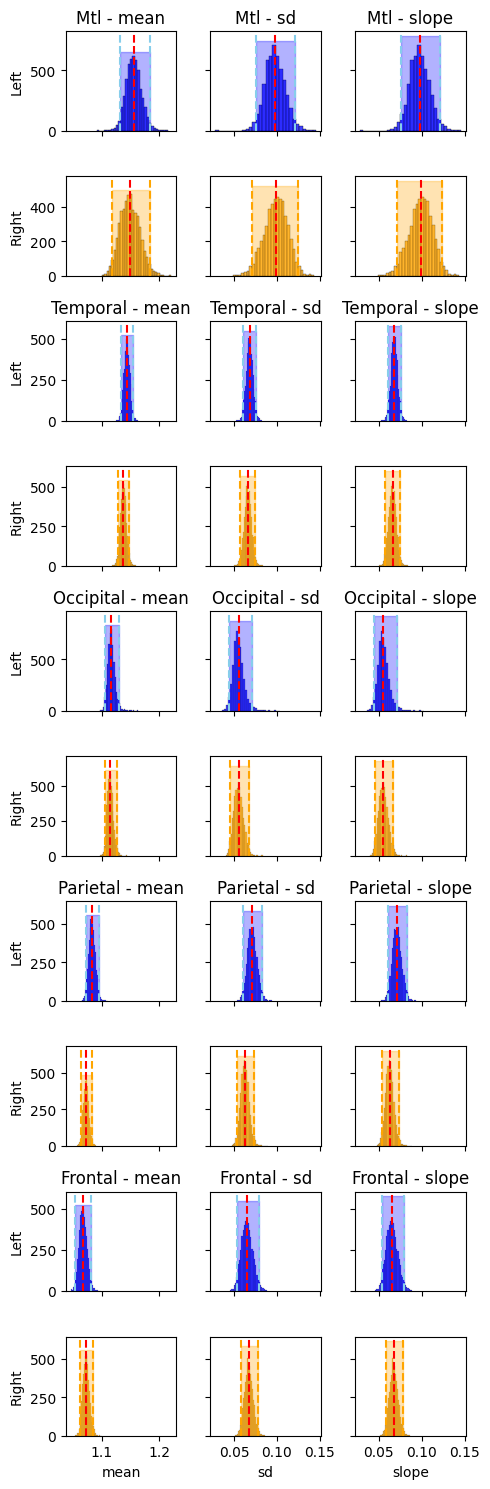

In [132]:
def plot_histograms(df, rois, stats):
    fig, axes = plt.subplots(len(rois)*2, len(stats), figsize=(5,15), sharex='col', sharey='row')
    colors = plt.cm.tab20.colors
    
    for i, roi in enumerate(rois):
        for j, stat in enumerate(stats):
            left_data = df[(df['roi'] == roi) & (df['L/R'] == 'L') & (df['stat'] == stat)] #& (df['value'] >= 0.02)]
            right_data = df[(df['roi'] == roi) & (df['L/R'] == 'R') & (df['stat'] == stat)] #& (df['value'] >= 0.02)]
            
            color_idx = (i * len(stats) + j) % len(colors)
            color = colors[color_idx]
            
            if not left_data.empty:
                sns.histplot(left_data['value'].explode(), ax=axes[i*2, j], kde=False, bins=30, color='blue')
                axes[i*2, j].set_title(f'{roi.capitalize()} - {stat}')
                axes[i*2, j].set_xlabel('')
                axes[i*2, j].set_ylabel('Left')
                mean_left = left_data['value'].mean()
                axes[i*2, j].axvline(mean_left, color='r', linestyle='--')  # Add mean line for left data
                # Calculate 95% confidence interval for left data
                conf_int_left = np.nanpercentile(left_data['value'], [2.5, 97.5])
                # Plot vertical lines for upper and lower bounds of 95% confidence interval
                axes[i*2, j].axvline(conf_int_left[0], color='skyblue', linestyle='--')
                axes[i*2, j].axvline(conf_int_left[1], color='skyblue', linestyle='--')
                # Fill between the lines
                axes[i*2, j].fill_betweenx(axes[i*2, j].get_ylim(), conf_int_left[0], conf_int_left[1], color='blue', alpha=0.3)

            if not right_data.empty:
                sns.histplot(right_data['value'].explode(), ax=axes[i*2+1, j], kde=False, bins=30, color='orange')
                axes[i*2+1, j].set_xlabel(stat)
                axes[i*2+1, j].set_ylabel('Right')
                mean_right = right_data['value'].mean()
                axes[i*2+1, j].axvline(mean_right, color='r', linestyle='--')  # Add mean line for right data
                # Calculate 95% confidence interval for right data
                conf_int_right = np.nanpercentile(right_data['value'], [2.5, 97.5])
                # Plot vertical lines for upper and lower bounds of 95% confidence interval
                axes[i*2+1, j].axvline(conf_int_right[0], color='orange', linestyle='--')
                axes[i*2+1, j].axvline(conf_int_right[1], color='orange', linestyle='--')
                # Fill between the lines
                axes[i*2+1, j].fill_betweenx(axes[i*2+1, j].get_ylim(), conf_int_right[0], conf_int_right[1], color='orange', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Define ROIs and stats
rois = ['MTL','temporal','occipital','parietal','frontal']  # Add more ROIs as needed
stats = ['mean', 'sd', 'slope']

# Assuming `results_long` is your DataFrame with appropriate data
# results_long = pd.read_csv('path/to/your/data.csv')

# Plot histograms
plot_histograms(results_long, rois, stats)


## init laterality?

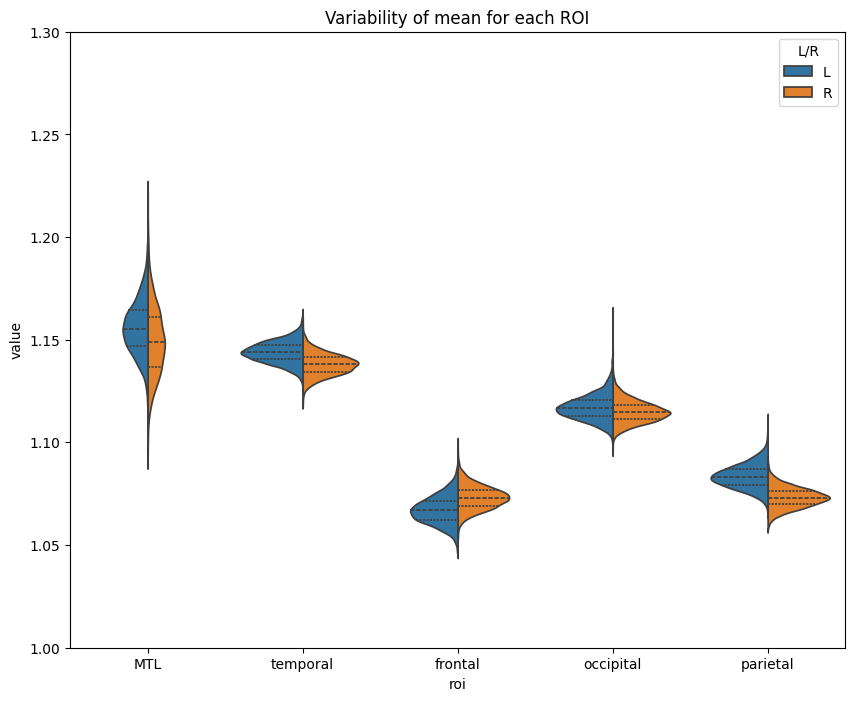

In [133]:
stat = 'mean'
plt.figure(figsize=(10,8))
plt.ylim([1.0,1.3])
#fscb = scb[scb.value < 10]
#fscb = fscb[fscb.value > -5]
sns.violinplot(x='roi', y='value', data=results_long[results_long.stat==stat], hue='L/R', split=True,inner='quart')
plt.title(f'Variability of {stat} for each ROI')
plt.show()


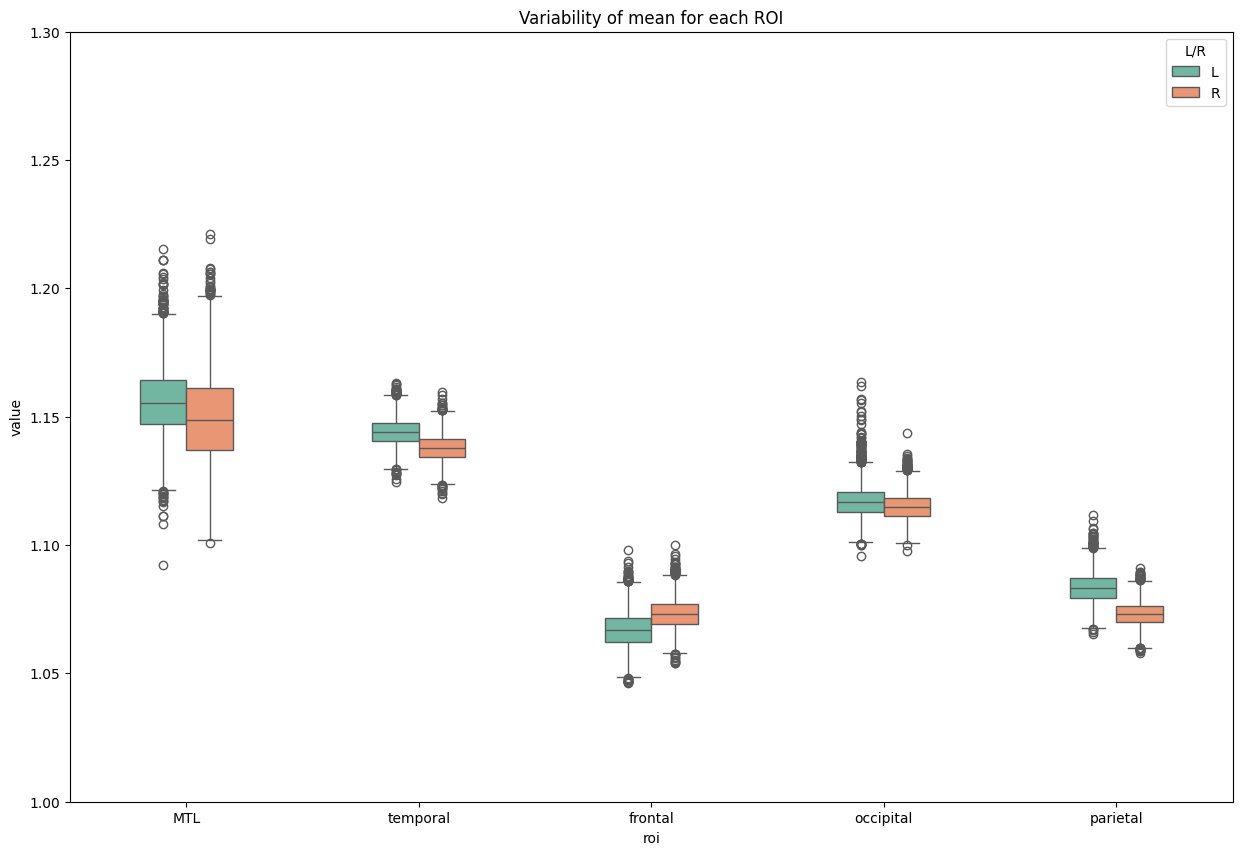

In [134]:
 

plt.figure(figsize=(15, 10))
plt.ylim([1,1.3])
sns.boxplot(x='roi', y='value', hue='L/R', data=results_long[results_long['stat'] == stat], palette='Set2', width=0.4)
#sns.swarmplot(x='roi', y='value', hue='L/R', data=scb[scb['stat'] == 'z'], palette='Set2', dodge=True, size=5) too many points. 
plt.title(f'Variability of {stat} for each ROI')
plt.legend(title='L/R')
plt.show()


## diff - stat test

In [135]:
results_long.head(2)

,roi,method,stat,value,L/R
1,MTL,gmm2,mean,1.155414,L
5,MTL,gmm2,mean,1.143736,R


In [136]:
results_long.stat.value_counts()

stat
mean         50000
sd           50000
bic          50000
intercept    50000
slope        50000
seed         50000
Name: count, dtype: int64

In [137]:
results_long['L/R'].value_counts()

L/R
L    150000
R    150000
Name: count, dtype: int64

In [138]:
results_long['roi'].value_counts()

roi
MTL          60000
temporal     60000
frontal      60000
occipital    60000
parietal     60000
Name: count, dtype: int64

In [140]:
results_long[results_long.value.isna()]

,roi,method,stat,value,L/R


In [142]:
rf = results_long[results_long.stat==stat]
diff = rf[rf['L/R'] == 'L']['value'].values - rf[rf['L/R'] == 'R']['value'].values
scb_roi = rf[rf['L/R'] == 'L']['roi']
bdiff = pd.DataFrame({'difference':diff,'roi':scb_roi})

/tmp/ipykernel_2358247/3907667010.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=bdiff, x='roi', y='difference', palette='pastel')


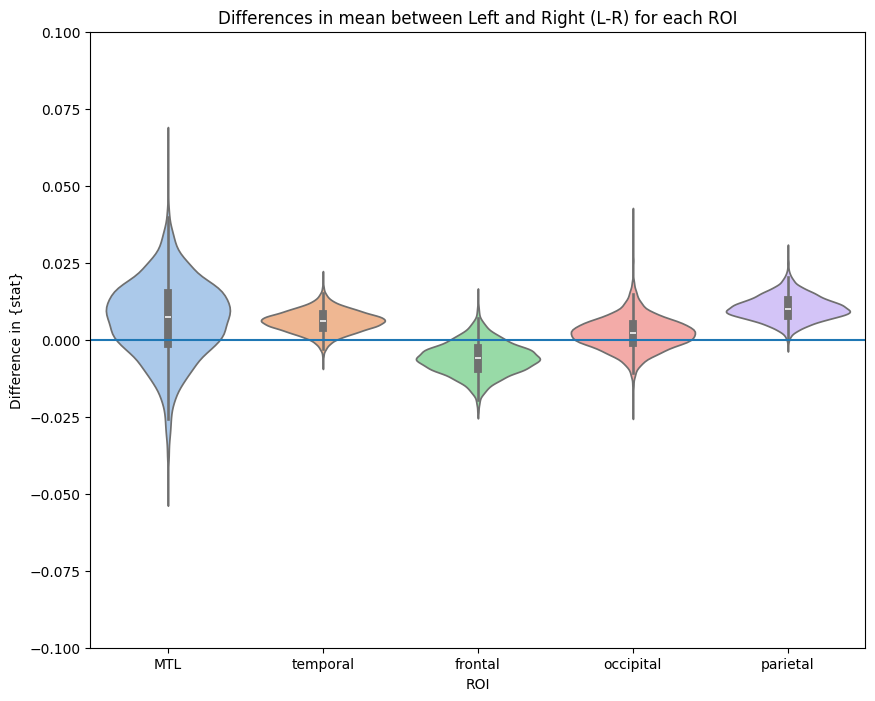

In [144]:
 
plt.figure(figsize=(10,8))
sns.violinplot(data=bdiff, x='roi', y='difference', palette='pastel')
#sns.stripplot(data=scbzdifff, x='roi', y='difference', color='black', alpha=0.5,size=0.01)
plt.title(f'Differences in {stat} between Left and Right (L-R) for each ROI')
plt.xlabel('ROI')
plt.ylabel('Difference in {stat}')
plt.axhline(y=0)
plt.ylim(-.1,0.1)  # Set the y-axis range from -1 to 1
plt.show()

In [145]:
from scipy.stats import ttest_1samp 
print('L-R')
# Perform hypothesis test for each ROI to test if the average difference is equal to zero
roi_list = bdiff['roi'].unique()
for roi in roi_list:
    roi_data = bdiff[bdiff['roi'] == roi]['difference']
    t_stat, p_value = ttest_1samp(roi_data, 0)
    
    # Calculate effect size (Cohen's d)
    mean_difference = np.mean(roi_data)
    std_dev = np.std(roi_data, ddof=1)  # Sample standard deviation
    cohen_d = mean_difference / std_dev
    
    print(f'Hypothesis Test for {roi}:')
    print(f'T-statistic: {t_stat}, p-value: {p_value}')
    print(f'Mean difference: {mean_difference}')
    print(f'Effect size (Cohen\'s d): {cohen_d}')
    
    if p_value < 0.05:
        print(f'Null hypothesis rejected: Average difference in {roi} is significantly different from zero.')
    else:
        print(f'Null hypothesis not rejected: Average difference in {roi} is not significantly different from zero.')
    print()


L-R
Hypothesis Test for MTL:
T-statistic: 37.37745372607049, p-value: 7.247085763532426e-270
Mean difference: 0.006677416619853848
Effect size (Cohen's d): 0.5285970198638168
Null hypothesis rejected: Average difference in MTL is significantly different from zero.

Hypothesis Test for temporal:
T-statistic: 120.46684688014138, p-value: 0.0
Mean difference: 0.0060055219522133305
Effect size (Cohen's d): 1.7036584867421891
Null hypothesis rejected: Average difference in temporal is significantly different from zero.

Hypothesis Test for frontal:
T-statistic: -82.7045153259689, p-value: 0.0
Mean difference: -0.006048032547523216
Effect size (Cohen's d): -1.1696184724347871
Null hypothesis rejected: Average difference in frontal is significantly different from zero.

Hypothesis Test for occipital:
T-statistic: 27.803020559580563, p-value: 2.5718778070137013e-158
Mean difference: 0.0021292492119909957
Effect size (Cohen's d): 0.3931940875029683
Null hypothesis rejected: Average difference i

## bs sample mean

In [154]:
#results.groupby(['roi','stat','method'])['value'].apply(np.nanmean).reset_index().to_csv(cpath+'bootstrapstat_exculde.csv',index=False)

# comparison

In [148]:
results.stat.unique()

array(['mean', 'sd', 'bic', 'intercept', 'slope', 'seed'], dtype=object)

In [118]:
methods = results.method.unique()
methods

array(['cn', 'gmm2', 'gmm2non', 'gmm3non'], dtype=object)

## comparison func

In [5]:
from scipy.stats import pearsonr, spearmanr

def contrast_plot_with_correlation(results_long, contrast_methods, 
                  method_names = {
                      'cn': 'CN',
                      'gmm2': '2GMM w/o EOnonAD',
                      'gmm2non': '2GMM w/ EOnonAD',
                      'gmm3non': '3GMM w/ EOnonAD'
                  }):
    """
    Plot contrast of interest between different methods for each ROI and compute correlation of slopes.

    Args:
    - results_long: DataFrame with columns ['roi', 'method', 'stat', 'value']
    - contrast_methods: List of methods to contrast, e.g., ['cn', 'gmm2', 'gmm3non']
    - method_names: Dictionary mapping method acronyms to full names for the legend

    Returns:
    - None (displays plot)
    """
    method_colors = {
        'cn': 'blue',
        'gmm2': 'orange',
        'gmm2non': 'green',
        'gmm3non': 'red'
    }
    linewidth = 2
    alpha = 0.3
    rois = results_long['roi'].unique()
    l_rois = [roi for roi in rois if roi.startswith('L_')]
    r_rois = [roi for roi in rois if roi.startswith('R_')]
    
    paired_rois = [(l, r) for l, r in zip(sorted(l_rois), sorted(r_rois))]

    fig, ax = plt.subplots(len(paired_rois), 2, figsize=(20, 25), sharey=True, sharex=True)
    ax = np.ravel(ax)

    for ii, (l_roi, r_roi) in enumerate(paired_rois):
        for col, roi in enumerate([l_roi, r_roi]):
            _ax = ax[ii * 2 + col]
            xvals = np.linspace(0.8, 4, 100)
            
            # Store slopes for correlation calculation
            slopes = {}

            for iLevel, level in enumerate(contrast_methods):
                data = results_long.query("(roi==@roi) & (method==@level)")
                
                # Calculate mean values from the bootstrap samples
                mu = data.query("stat == 'mean'")['value'].mean()
                sigma = data.query("stat == 'sd'")['value'].mean()
                
                zfunc = lambda x: (x - mu) / sigma
                yvals = zfunc(xvals)

                mu_boot = data.query("stat == 'mean'")['value'].values
                sigma_boot = data.query("stat == 'sd'")['value'].values
                yvals_boot = []
                for j in range(len(mu_boot)):
                    zfunc_boot = lambda x: (x - mu_boot[j]) / sigma_boot[j]
                    yvals_boot.append(zfunc_boot(xvals))
                yvals_boot = np.array(yvals_boot)
                ci_lower = np.percentile(yvals_boot, 2.5, axis=0)
                ci_upper = np.percentile(yvals_boot, 97.5, axis=0)

                _ax.plot(xvals, yvals, color=method_colors[level], lw=linewidth, label=method_names[level])
                _ax.fill_between(xvals, ci_lower, ci_upper, color=method_colors[level], alpha=alpha, lw=0, zorder=0)

                # Calculate the slope using the mean values
                slope = (yvals[-1] - yvals[0]) / (xvals[-1] - xvals[0])
               
                intercept = yvals[0] - slope * xvals[0]
                sign_intercept = "+" if intercept >= 0 else "-"
                _ax.text(0.05, 0.9 - 0.1 * iLevel, f"z = {slope:.2f} * value {sign_intercept} {abs(intercept):.2f}",
                         transform=_ax.transAxes, fontsize=15, color=method_colors[level], verticalalignment='top')

            # Compute correlation between the slopes and annotate
            if len(contrast_methods) == 2:
                method1, method2 = contrast_methods
                corr_coef, p_value = pearsonr(
                    results_long[(results_long['roi'] == roi) & (results_long['method'] == method1) & (results_long['stat'] == 'slope')]['value'],
                    results_long[(results_long['roi'] == roi) & (results_long['method'] == method2) & (results_long['stat'] == 'slope')]['value']
                )
                _ax.text(0.05, 0.05, f"r = {corr_coef:.2f}, p = {p_value:.3f}", transform=_ax.transAxes, fontsize=15, color='black')

            if col == 0:
                region_name = l_roi.split('_')[1]
                if region_name != 'MTL':
                    region_name = region_name.capitalize()
                _ax.set_title(region_name, fontsize=16, loc='left')
            else:
                _ax.set_title('')
            _ax.set_xlabel('')
            _ax.set_ylabel('')
            
            if ii == 0 and col == 0:
                _ax.legend(title='Method', fontsize=15)

            if ii == len(paired_rois) - 1:
                if col == 0:
                    _ax.set_xlabel('Left', fontsize=16)
                else:
                    _ax.set_xlabel('Right', fontsize=16)
            _ax.tick_params(axis='both', which='major', labelsize=15)

    contrast_str = " vs ".join([method_names[method] for method in contrast_methods])
    fig.suptitle(f"Contrast of Interest: {contrast_str}", fontsize=18)
    fig.text(0.5, 0.04, 'SUVR', ha='center', fontsize=16)
    fig.text(0.04, 0.5, 'Z-score', va='center', rotation='vertical', fontsize=16)
    
    fig.tight_layout(rect=[0.05, 0.05, 1, 1])
    plt.show()


In [6]:
from scipy.stats import pearsonr, spearmanr

def contrast_plot_with_correlation(results_long, contrast_methods, 
                  method_names = {
                      'cn': 'CN',
                      'gmm2': '2GMM w/o EOnonAD',
                      'gmm2non': '2GMM w/ EOnonAD',
                      'gmm3non': '3GMM w/ EOnonAD'
                  }, value_to_transform=1.63):
    """
    Plot contrast of interest between different methods for each ROI and compute correlation of transformed values.

    Args:
    - results_long: DataFrame with columns ['roi', 'method', 'stat', 'value']
    - contrast_methods: List of methods to contrast, e.g., ['cn', 'gmm2', 'gmm3non']
    - method_names: Dictionary mapping method acronyms to full names for the legend
    - value_to_transform: The value to transform using the slopes and intercepts

    Returns:
    - None (displays plot)
    """
    method_colors = {
        'cn': 'blue',
        'gmm2': 'orange',
        'gmm2non': 'green',
        'gmm3non': 'red'
    }
    linewidth = 2
    alpha = 0.3
    rois = results_long['roi'].unique()
    l_rois = [roi for roi in rois if roi.startswith('L_')]
    r_rois = [roi for roi in rois if roi.startswith('R_')]
    
    paired_rois = [(l, r) for l, r in zip(sorted(l_rois), sorted(r_rois))]

    fig, ax = plt.subplots(len(paired_rois), 2, figsize=(20, 25), sharey=True, sharex=True)
    ax = np.ravel(ax)

    for ii, (l_roi, r_roi) in enumerate(paired_rois):
        for col, roi in enumerate([l_roi, r_roi]):
            _ax = ax[ii * 2 + col]
            xvals = np.linspace(0.8, 4, 100)
            
            # Store transformed values for correlation calculation
            transformed_values = {}

            for iLevel, level in enumerate(contrast_methods):
                data = results_long.query("(roi==@roi) & (method==@level)")

                # Extract slope and intercept from the bootstrap samples
                slopes = data.query("stat == 'slope'")['value'].values
                intercepts = data.query("stat == 'intercept'")['value'].values
                
                # Transform the value using the slope and intercept
                transformed_values[level] = slopes * value_to_transform + intercepts

                # Plotting (mean and CI)
                mu = data.query("stat == 'mean'")['value'].mean()
                sigma = data.query("stat == 'sd'")['value'].mean()
                zfunc = lambda x: (x - mu) / sigma
                yvals = zfunc(xvals)
                
                mu_boot = data.query("stat == 'mean'")['value'].values
                sigma_boot = data.query("stat == 'sd'")['value'].values
                yvals_boot = []
                for j in range(len(mu_boot)):
                    zfunc_boot = lambda x: (x - mu_boot[j]) / sigma_boot[j]
                    yvals_boot.append(zfunc_boot(xvals))
                yvals_boot = np.array(yvals_boot)
                ci_lower = np.percentile(yvals_boot, 2.5, axis=0)
                ci_upper = np.percentile(yvals_boot, 97.5, axis=0)

                _ax.plot(xvals, yvals, color=method_colors[level], lw=linewidth, label=method_names[level])
                _ax.fill_between(xvals, ci_lower, ci_upper, color=method_colors[level], alpha=alpha, lw=0, zorder=0)

                # Annotate the equation
                slope = (yvals[-1] - yvals[0]) / (xvals[-1] - xvals[0])
                intercept = yvals[0] - slope * xvals[0]
                sign_intercept = "+" if intercept >= 0 else "-"
                _ax.text(0.05, 0.9 - 0.1 * iLevel, f"z = {slope:.2f} * value {sign_intercept} {abs(intercept):.2f}",
                         transform=_ax.transAxes, fontsize=15, color=method_colors[level], verticalalignment='top')

            # Compute correlation between the transformed values
            if len(contrast_methods) == 2:
                method1, method2 = contrast_methods
                corr_coef, p_value = pearsonr(
                    transformed_values[method1],
                    transformed_values[method2]
                )
                _ax.text(0.05, 0.05, f"r = {corr_coef:.2f}, p = {p_value:.3f}", transform=_ax.transAxes, fontsize=15, color='black')

            if col == 0:
                region_name = l_roi.split('_')[1]
                if region_name != 'MTL':
                    region_name = region_name.capitalize()
                _ax.set_title(region_name, fontsize=16, loc='left')
            else:
                _ax.set_title('')
            _ax.set_xlabel('')
            _ax.set_ylabel('')
            
            if ii == 0 and col == 0:
                _ax.legend(title='Method', fontsize=15)

            if ii == len(paired_rois) - 1:
                if col == 0:
                    _ax.set_xlabel('Left', fontsize=16)
                else:
                    _ax.set_xlabel('Right', fontsize=16)
            _ax.tick_params(axis='both', which='major', labelsize=15)

    contrast_str = " vs ".join([method_names[method] for method in contrast_methods])
    fig.suptitle(f"Contrast of Interest: {contrast_str}", fontsize=18)
    fig.text(0.5, 0.04, 'SUVR', ha='center', fontsize=16)
    fig.text(0.04, 0.5, 'Z-score', va='center', rotation='vertical', fontsize=16)
    
    fig.tight_layout(rect=[0.05, 0.05, 1, 1])
    plt.show()


In [159]:
bstat = pd.read_csv(cpath+'bootstrapstat_exculde.csv')

## 2 vs 3  
 "2 vs 3 component": ("2-comp GMM with EOAD+EOnonAD+Controls", "3-comp GMM with EOAD+EOnonAD+Controls"),
​

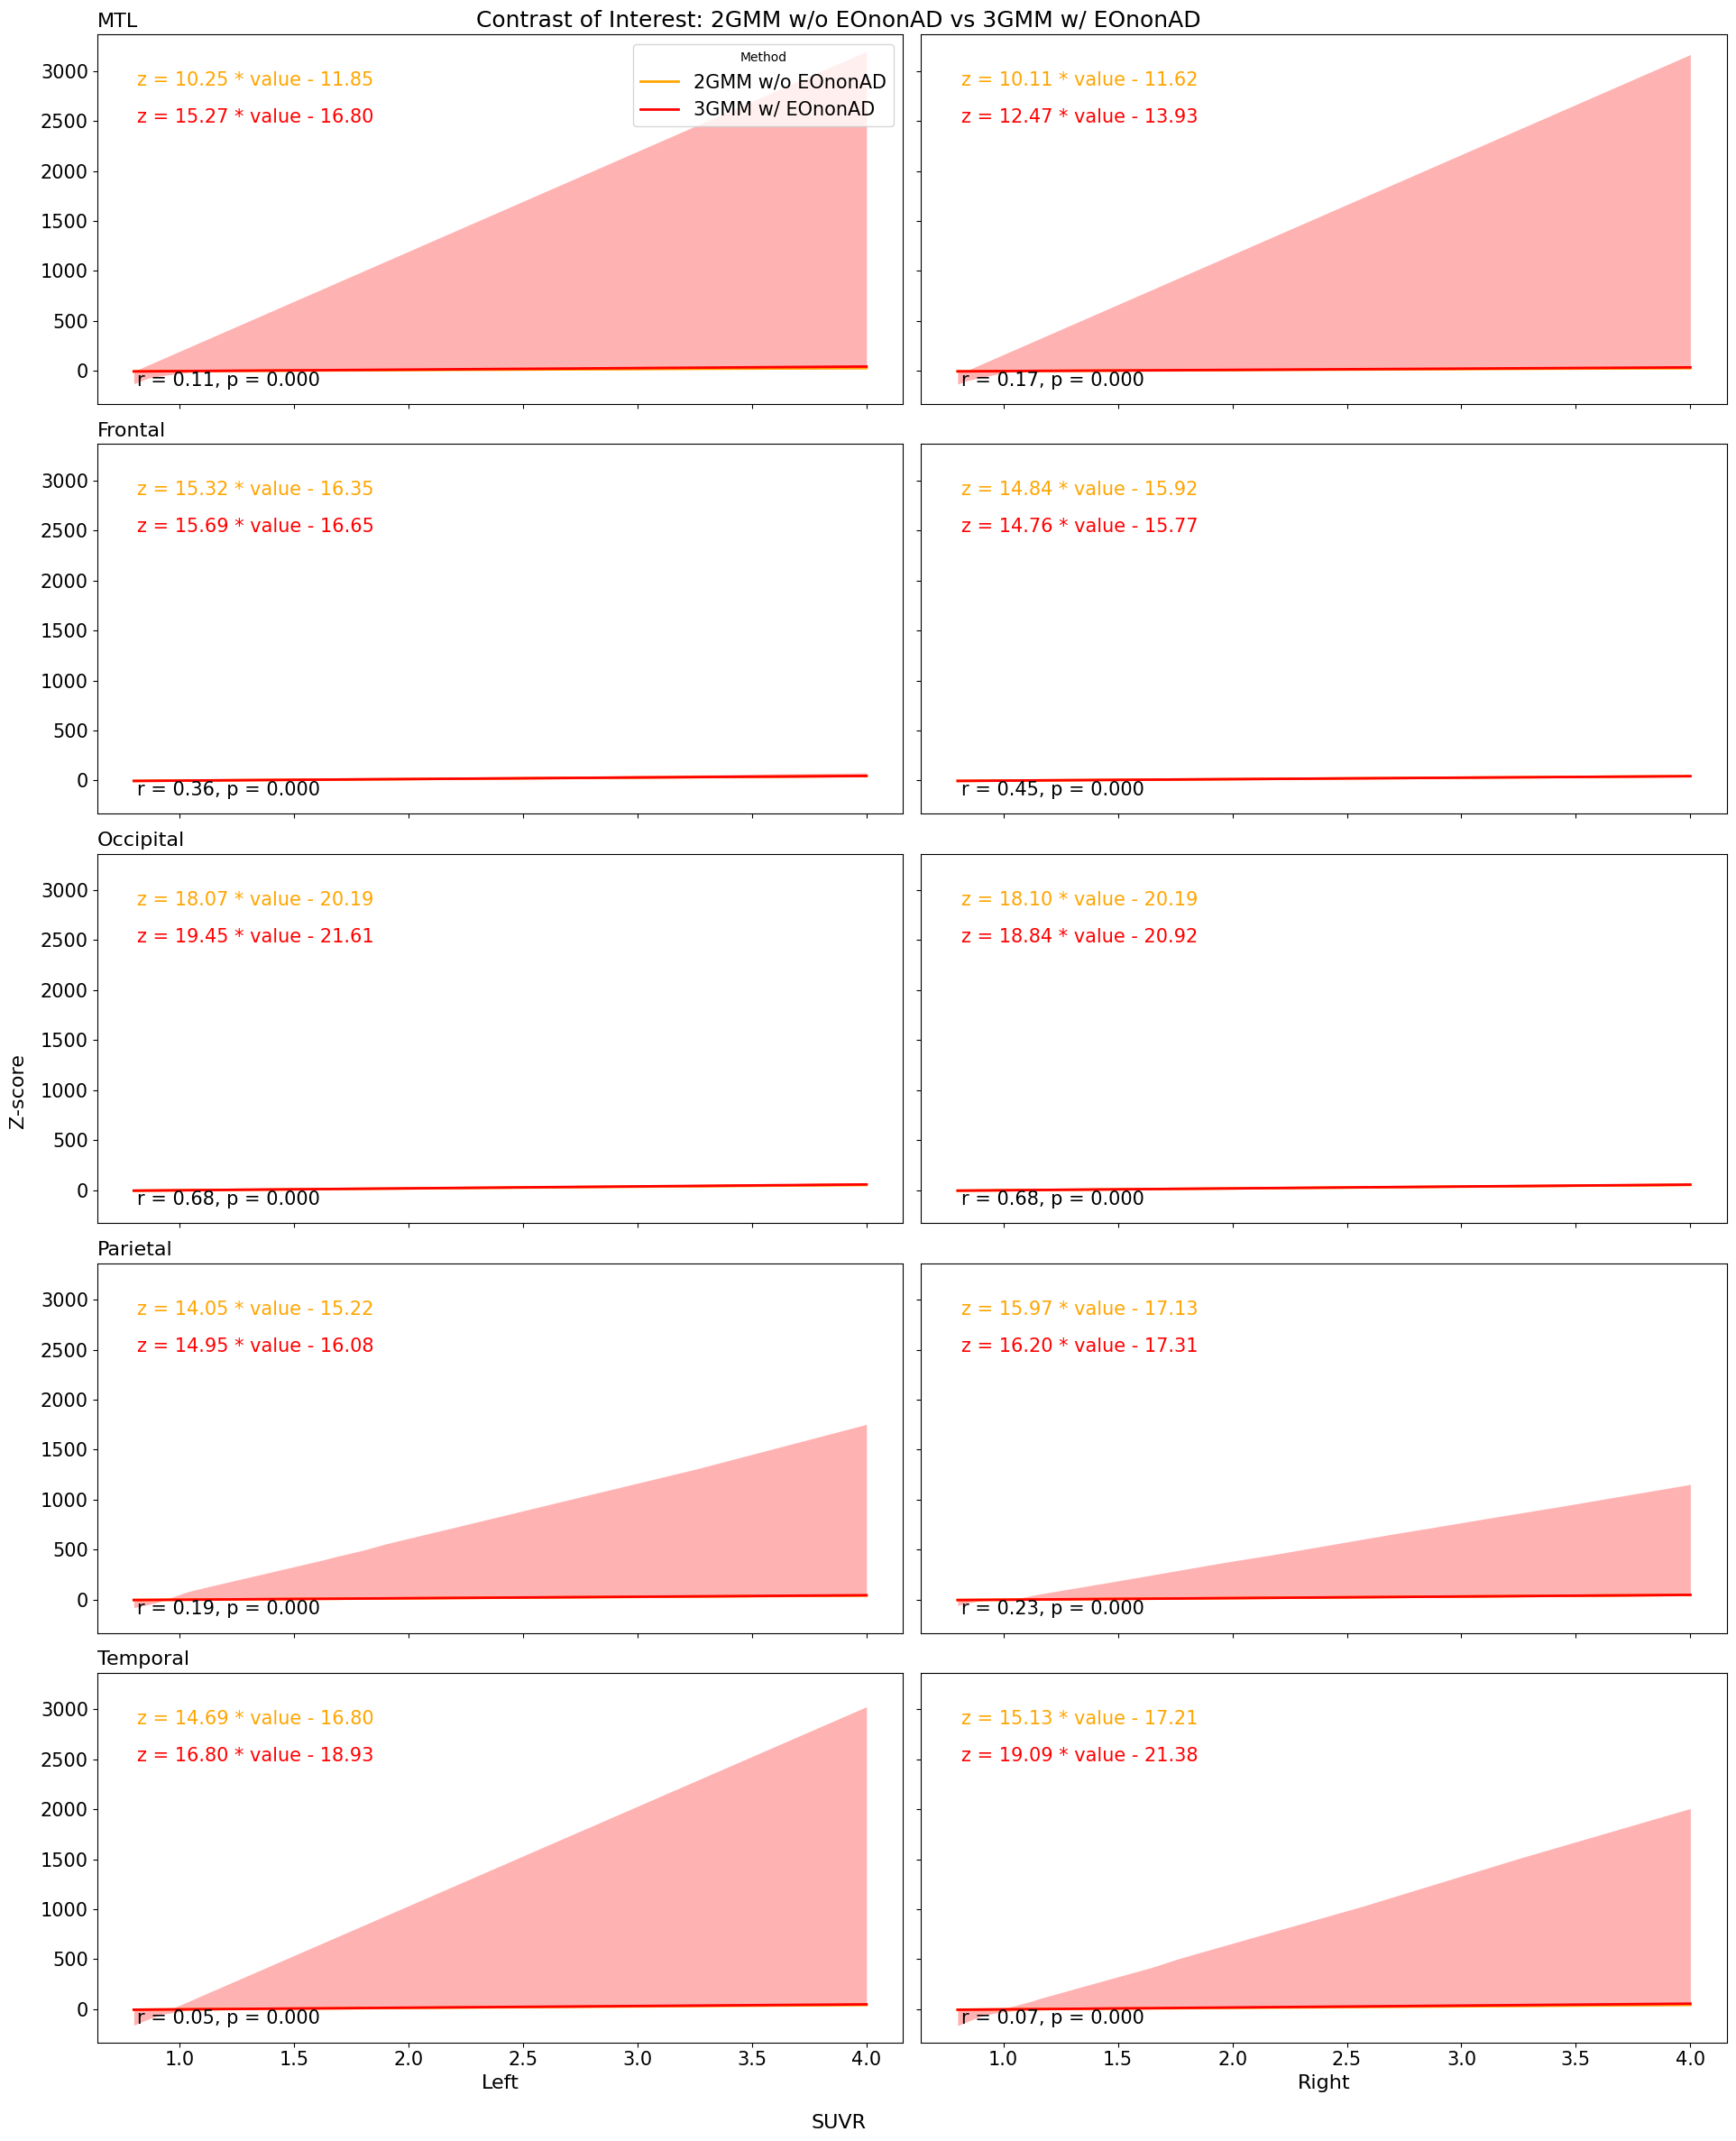

In [9]:
contrast_plot_with_correlation(results, ['gmm2', 'gmm3non'])

## CN vs GMM
 "Control-based vs GMM": ("control-based z-scoring", "2-comp GMM with EOAD+EOnonAD+Controls"),

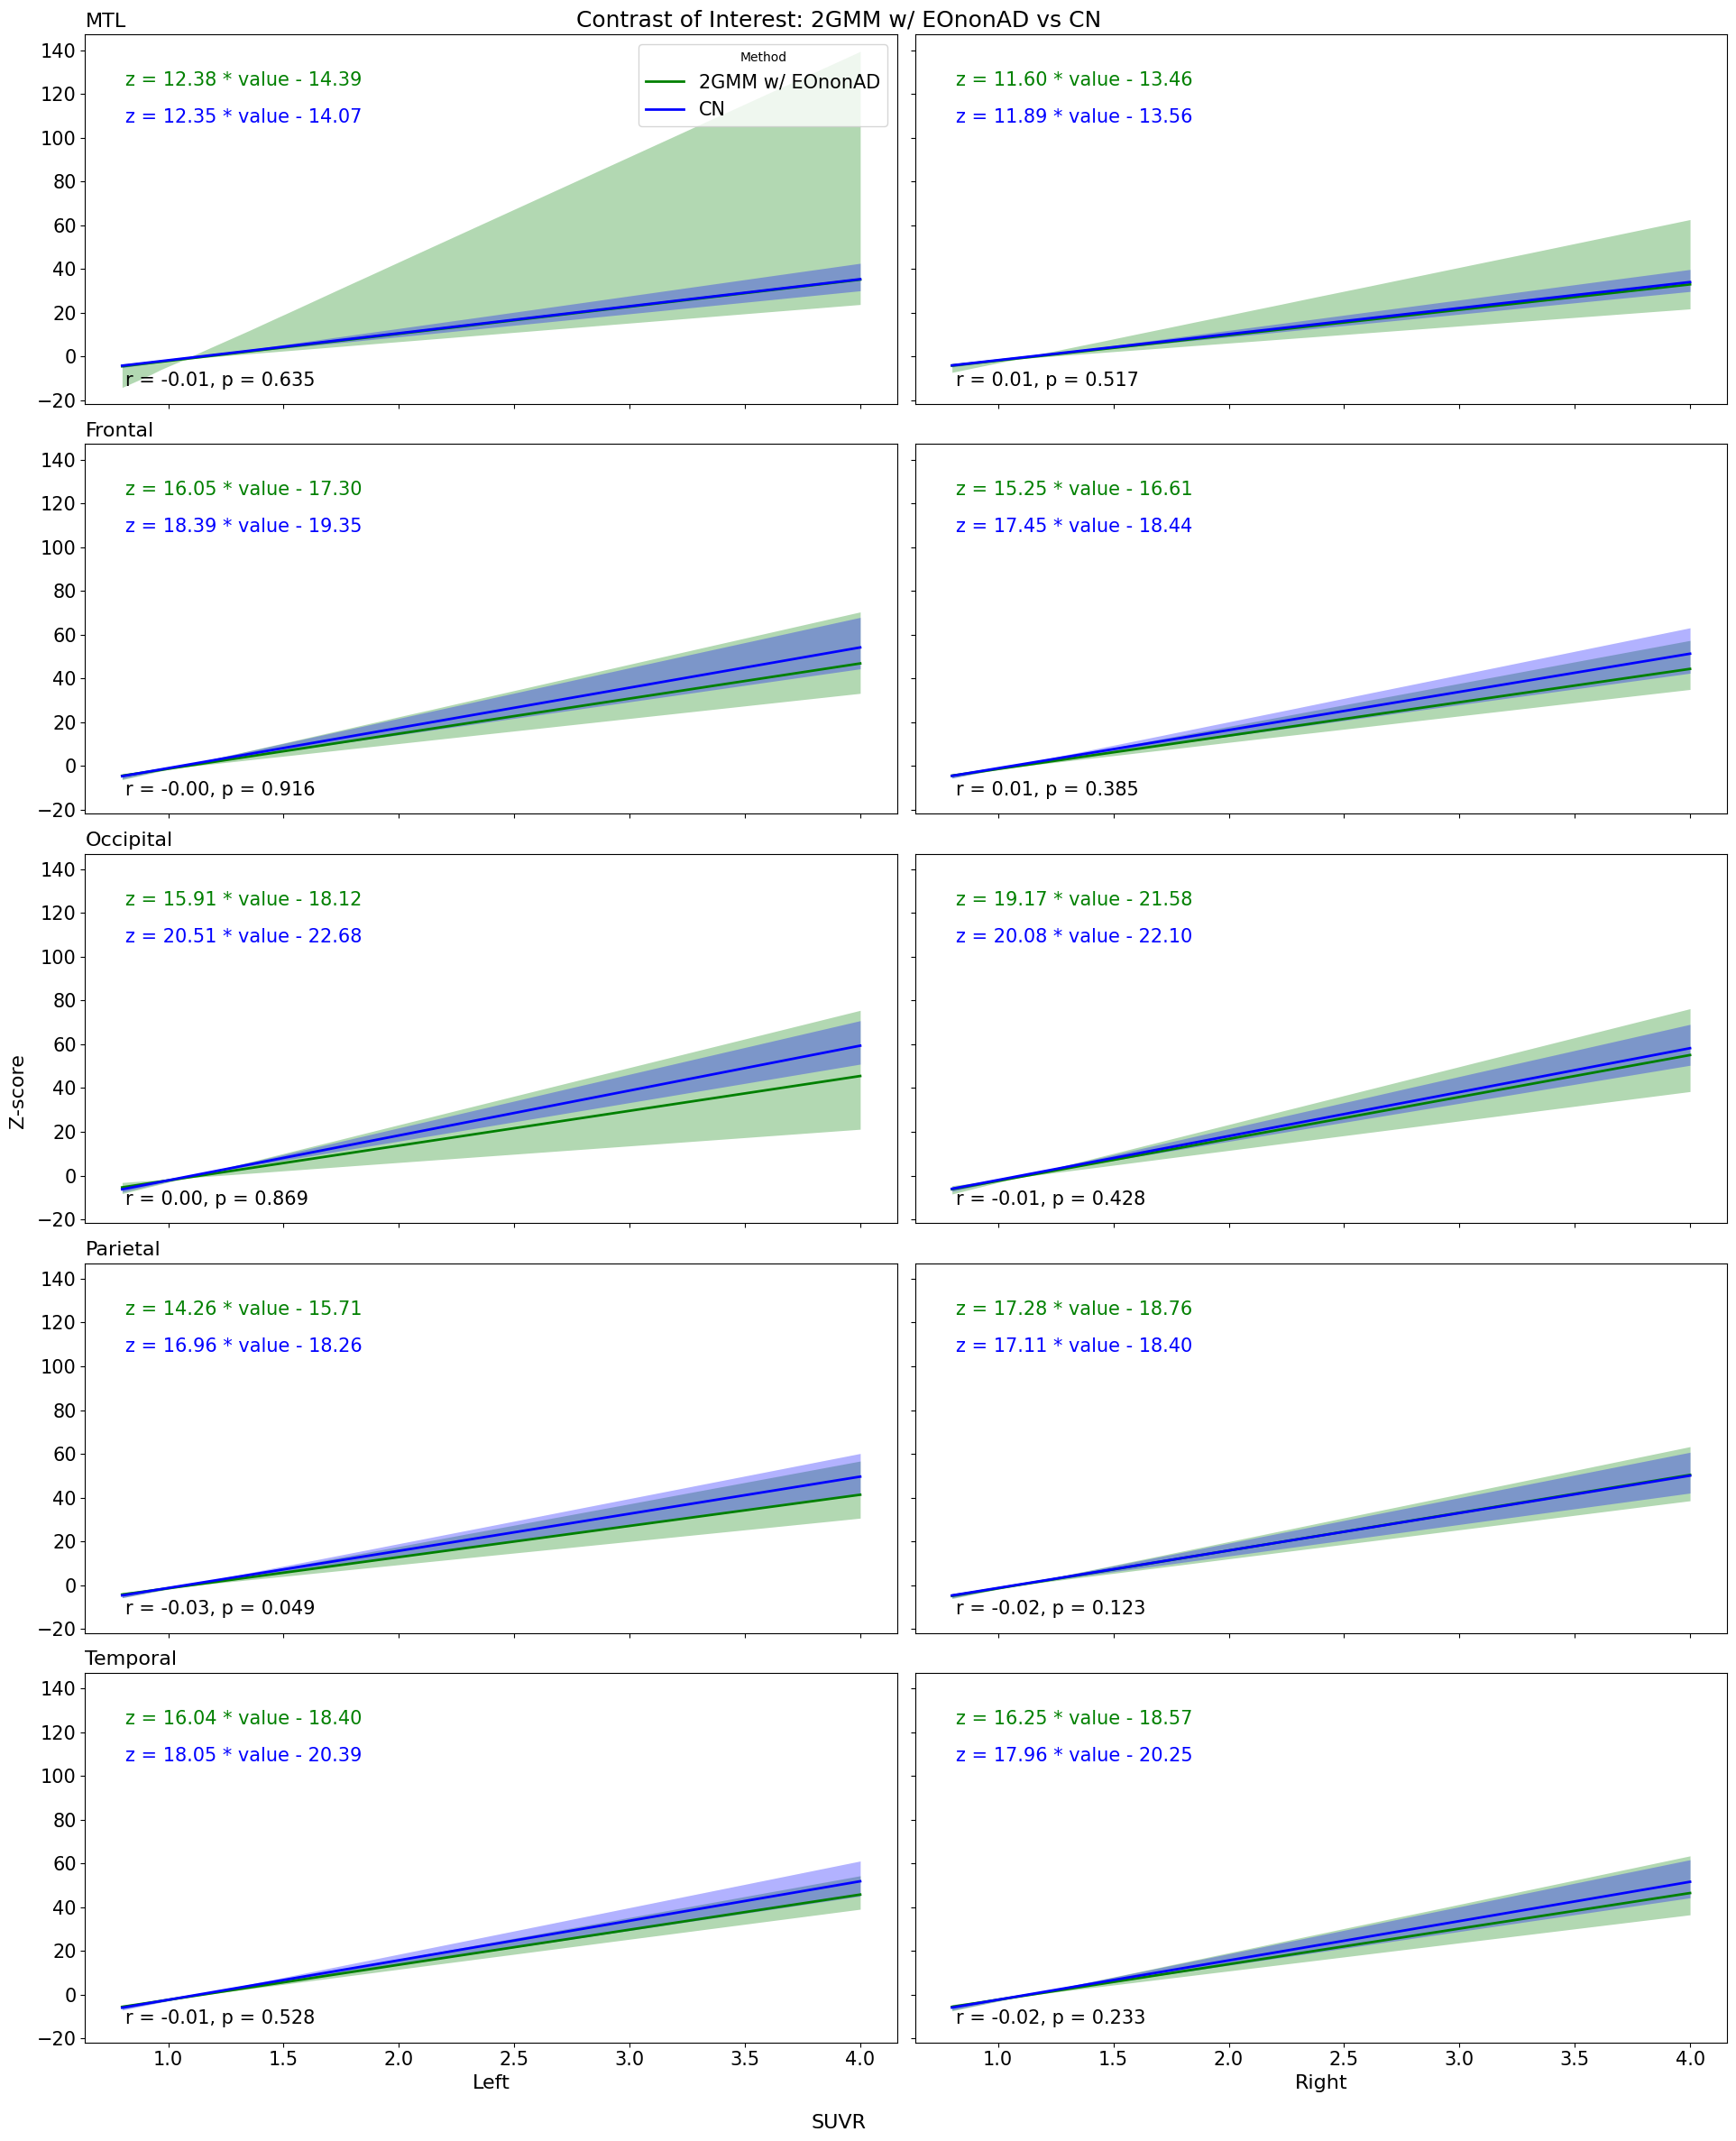

In [167]:
contrast_plot_with_correlation(results, ['gmm2non', 'cn'])

## w or w/o EOnonAD
  "w vs w/o EOnonAD": ("2-comp GMM with EOAD+Controls", "2-comp GMM with EOAD+EOnonAD+Controls"),​

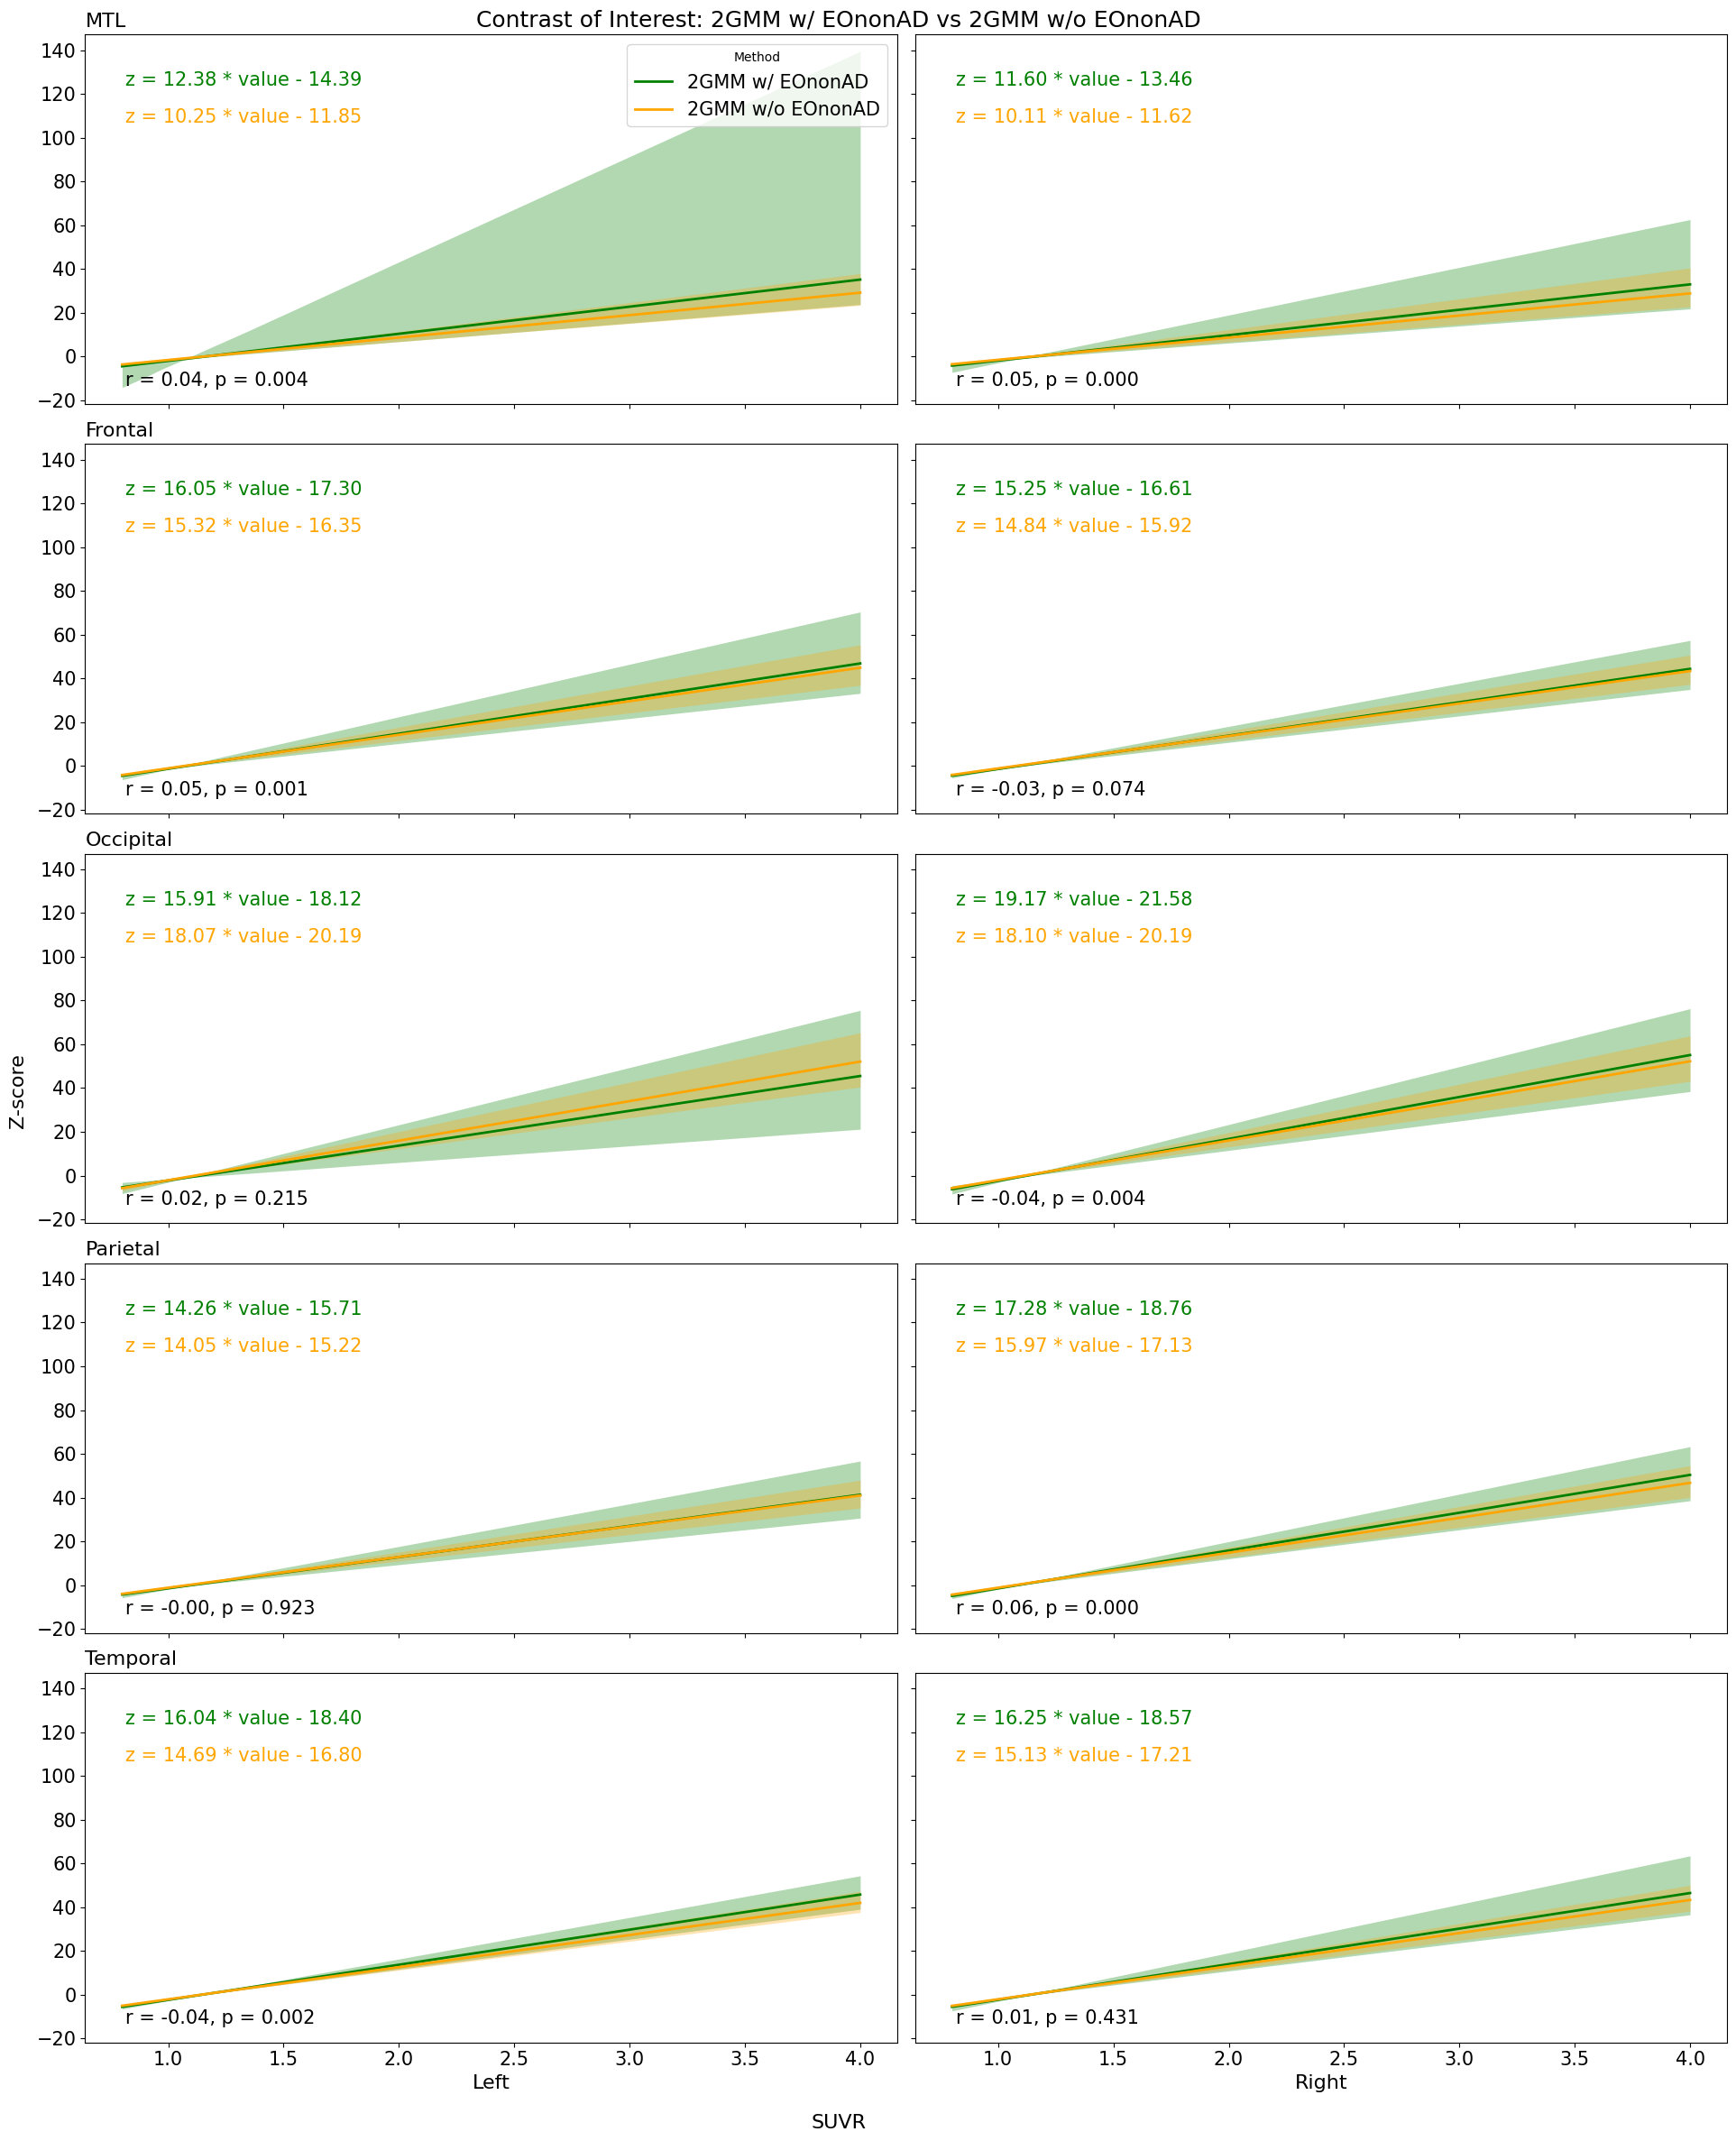

In [169]:
contrast_plot_with_correlation(results, ['gmm2non', 'gmm2'])

## 3 methods

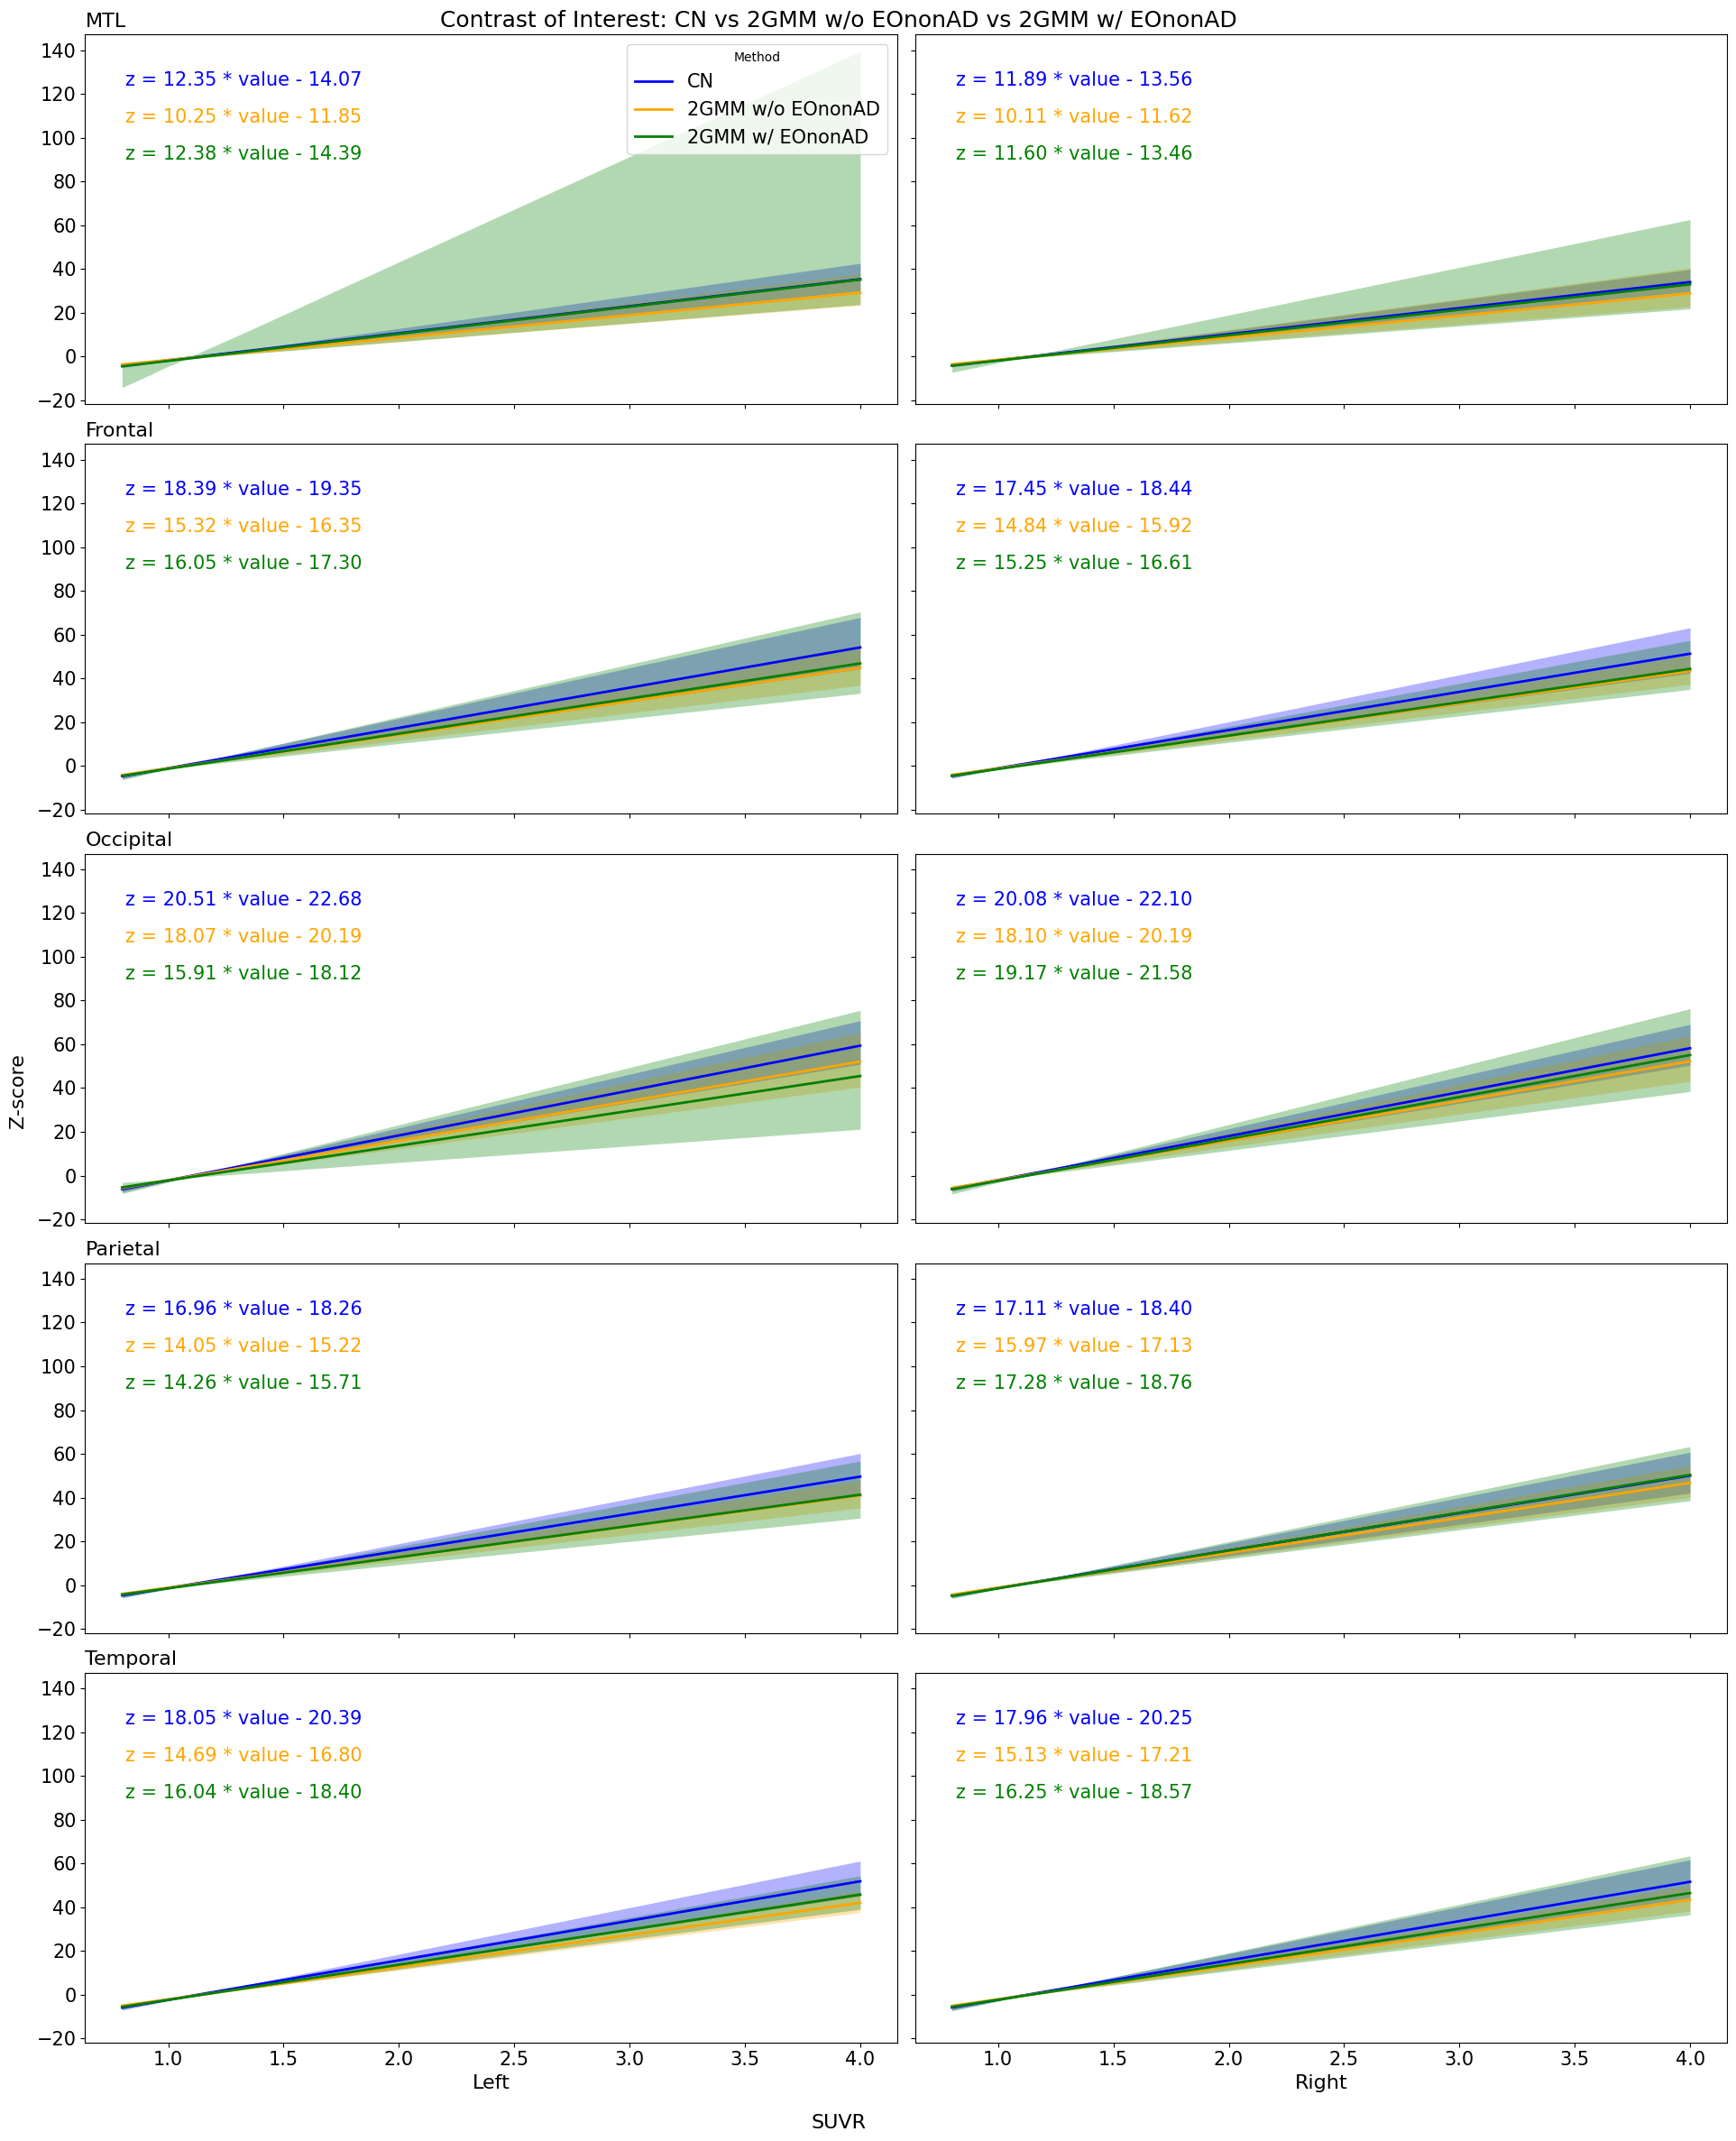

In [171]:
contrast_plot_with_correlation(results, ['cn', 'gmm2','gmm2non'])

# violin

In [173]:
from scipy.stats import ttest_rel 

def roi_cluster_violin(data, title_text, labels, strip=True, colors=sns.color_palette('tab20'), range = [0.5,4.5],**kwargs):
    # Define the pairs
    pairs = [
        ('L_MTL', 'R_MTL'),
        ('L_temporal', 'R_temporal'),
        ('L_frontal', 'R_frontal'),
        ('L_occipital', 'R_occipital'),
        ('L_parietal', 'R_parietal')
    ]
    fig, axes = plt.subplots(5, 1, figsize=(6, 25), sharey=True) #change to 9 for three groups

    for i, (lobe_l, lobe_r) in enumerate(pairs):
        ax = axes[i]

        # Plot the violin plot
        sns.violinplot(data=data[data['lobe'].isin([lobe_l, lobe_r])], x='dx', y='value', hue='lobe', 
                       split=True, inner='quart', ax=ax, palette=colors, **kwargs)
        
        # Plot the strip plot
        if strip:
            sns.stripplot(data=data[data['lobe'].isin([lobe_l, lobe_r])], x='dx', y='value', hue='lobe', 
                          dodge=True, jitter=True, alpha=0.5, size=4, legend=False, ax=ax, palette=colors)
        
        # plot the median lines
        #for line in ax.lines:
        for i in [1,4,7,10]: #ax.lines has length 12
            ax.lines[i].set_linestyle('-')
            ax.lines[i].set_linewidth(3)
        
        # Calculate the p-values for each dx group
        p_values = {}
        dx_groups = data['dx'].unique()
        for dxi, dx in enumerate(dx_groups):
            group_data = data[(data['lobe'].isin([lobe_l, lobe_r])) & (data['dx'] == dx)]
            left_data = group_data[group_data['lobe'] == lobe_l]['value']
            right_data = group_data[group_data['lobe'] == lobe_r]['value']
            if len(left_data) > 0 and len(right_data) > 0:
                t_stat, p_value = ttest_rel(left_data, right_data)
                p_values[dx] = p_value
                ax.text(ax.get_xlim()[1] * (0.20 * (dxi+1)), 0.95, f'{dx} p={p_value:.3f}', ha='center', va='center', transform=ax.transAxes, fontsize=12, color='black')
                                            #chage to 0.1 for 3
        # Set subplot titles and labels
        ax.set_title(f'{lobe_l[2:]} vs {lobe_r[2:]}', fontsize=16)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_ylim(range)
        ax.tick_params(axis='y', labelsize=14)
        ax.tick_params(axis='x', labelsize=14)

        # Set legend to None for all subplots except the last one
        handles, _ = ax.get_legend_handles_labels()
        ax.legend().set_visible(False)

        # Add overall p-value in the subplot title
        overall_p_value = ttest_rel(data[data['lobe'] == lobe_l]['value'], data[data['lobe'] == lobe_r]['value']).pvalue
        ax.set_title(f'{lobe_l[2:]} (p={overall_p_value:.3f})', fontsize=14)

    # Create a single legend in the first subplot
    axes[0].legend(handles, labels, loc='upper left', fontsize=12)
    plt.suptitle(title_text, fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.99])
    plt.show()

# Example usage:
# roi_cluster_violin(data=df, title_text='Comparison of ROIs', labels=['Left', 'Right'])


In [174]:
sns.color_palette('tab20')

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745)]

In [180]:
lftp = pd.read_csv(cpath+'long_mean_suvr.csv')

In [182]:
slftp = lftp[lftp.dx.isin(['EOAD','CN'])]
slftp.rename(columns={'mean_suvr':'value'},inplace=True)
slftp.head(2)

,subj,dx,lobe,ftp_date,visit,value
0,LDS0070120,CN,L_MTL,2019-06-20,1,1.211290
1,LDS0070120,CN,L_frontal,2019-06-20,1,1.042777


### mean suvr

/tmp/ipykernel_2358247/855265866.py:18: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.violinplot(data=data[data['lobe'].isin([lobe_l, lobe_r])], x='dx', y='value', hue='lobe',
/tmp/ipykernel_2358247/855265866.py:23: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.stripplot(data=data[data['lobe'].isin([lobe_l, lobe_r])], x='dx', y='value', hue='lobe',
/tmp/ipykernel_2358247/855265866.py:18: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.violinplot(data=data[data['lobe'].isin([lobe_l, lobe_r])], x='dx', y='value', hue='lobe',
/tmp/ipykernel_2358247/855265866.py:23: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.stripplot(data=data[data['lobe'].isin([lobe_l, lobe_r])], x='dx', y='value', hue='lobe',
/tmp/ipykernel_2358247/855265866.py:18: UserWarning: The palette list has more val

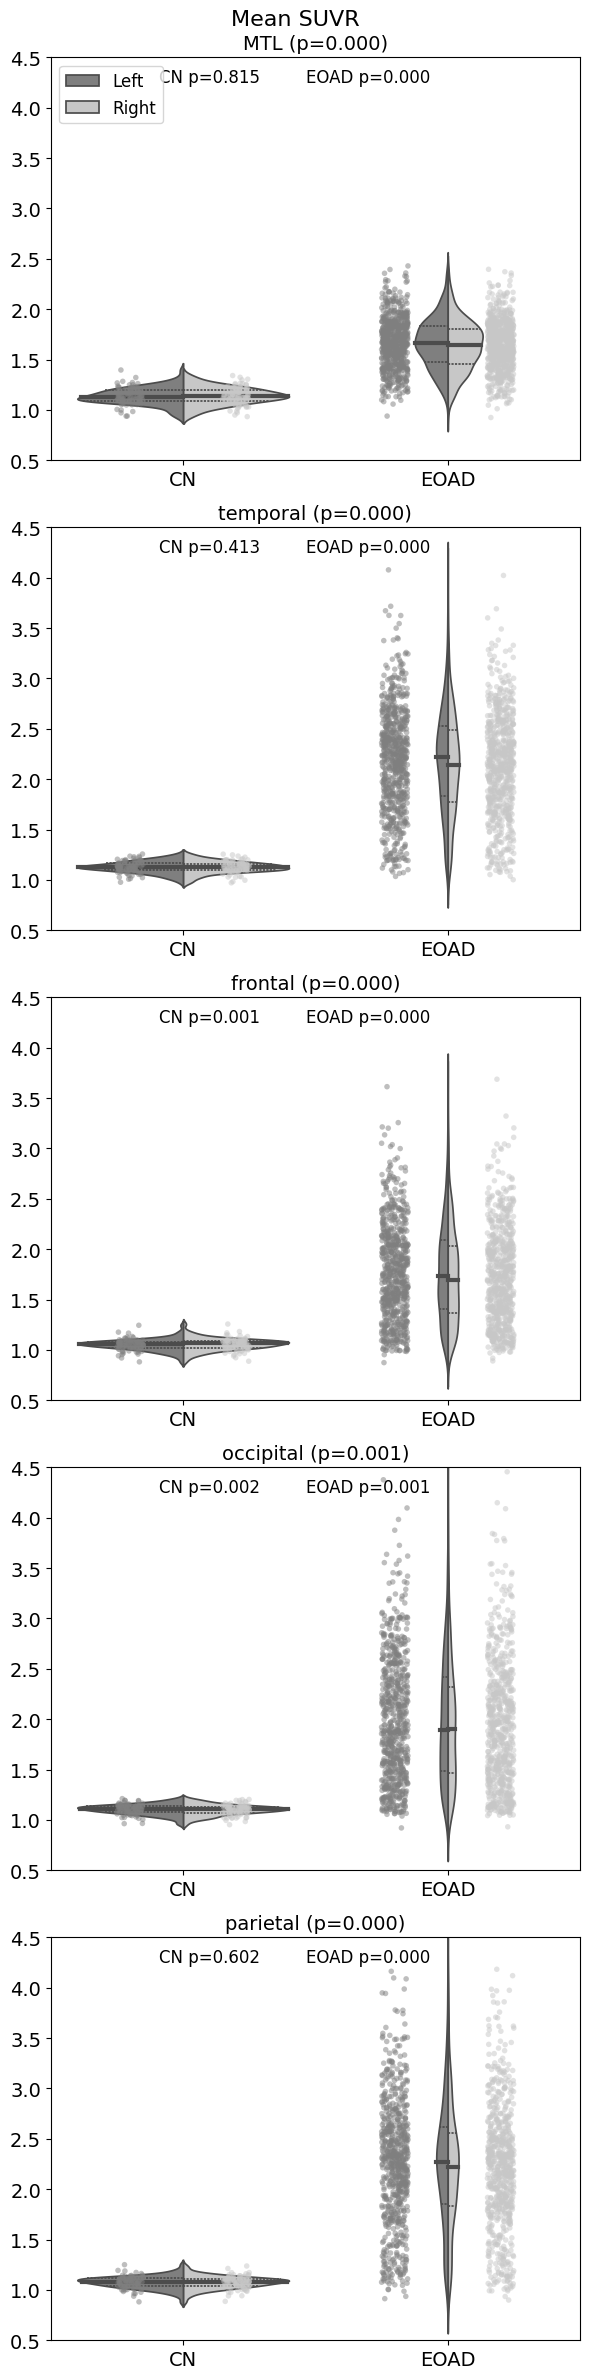

In [183]:
roi_cluster_violin(slftp,
                   title_text = 'Mean SUVR',
                   labels = ['Left','Right'],
                   strip = True,
                   colors = sns.color_palette('tab20')[14:])

### cnz

In [203]:
#zl = pd.melt(zdf, id_vars=['subj', 'dx'], var_name='lobe', value_name='value')

# Extract the 'L/R' and 'ROI' columns from the 'lobe' column
#zl['L/R'] = zl['lobe'].apply(lambda x: 'Left' if x.startswith('L_') else 'Right')
#zl['ROI'] = zl['lobe'].apply(lambda x: x.split('_')[1])
bzl = trans('cn')
bzl.to_csv(cpath+'bscnz_exclude.csv')
bzl

,subj,dx,lobe,value
0,LDS0070120,CN,L_MTL,0.883642
10,LDS0070166,EOAD,L_MTL,9.104383
11,LDS0070166,EOAD,L_MTL,8.306159
12,LDS0070166,EOAD,L_MTL,9.067431
13,LDS0070166,EOAD,L_MTL,8.748017
...,...,...,...,...
7799,LDS9410572,EOAD,R_temporal,18.294773
7809,LDS9410574,EOAD,R_temporal,29.918541
7819,LDS9410608,EOAD,R_temporal,18.578078
7829,LDS9410622,EOAD,R_temporal,3.520864


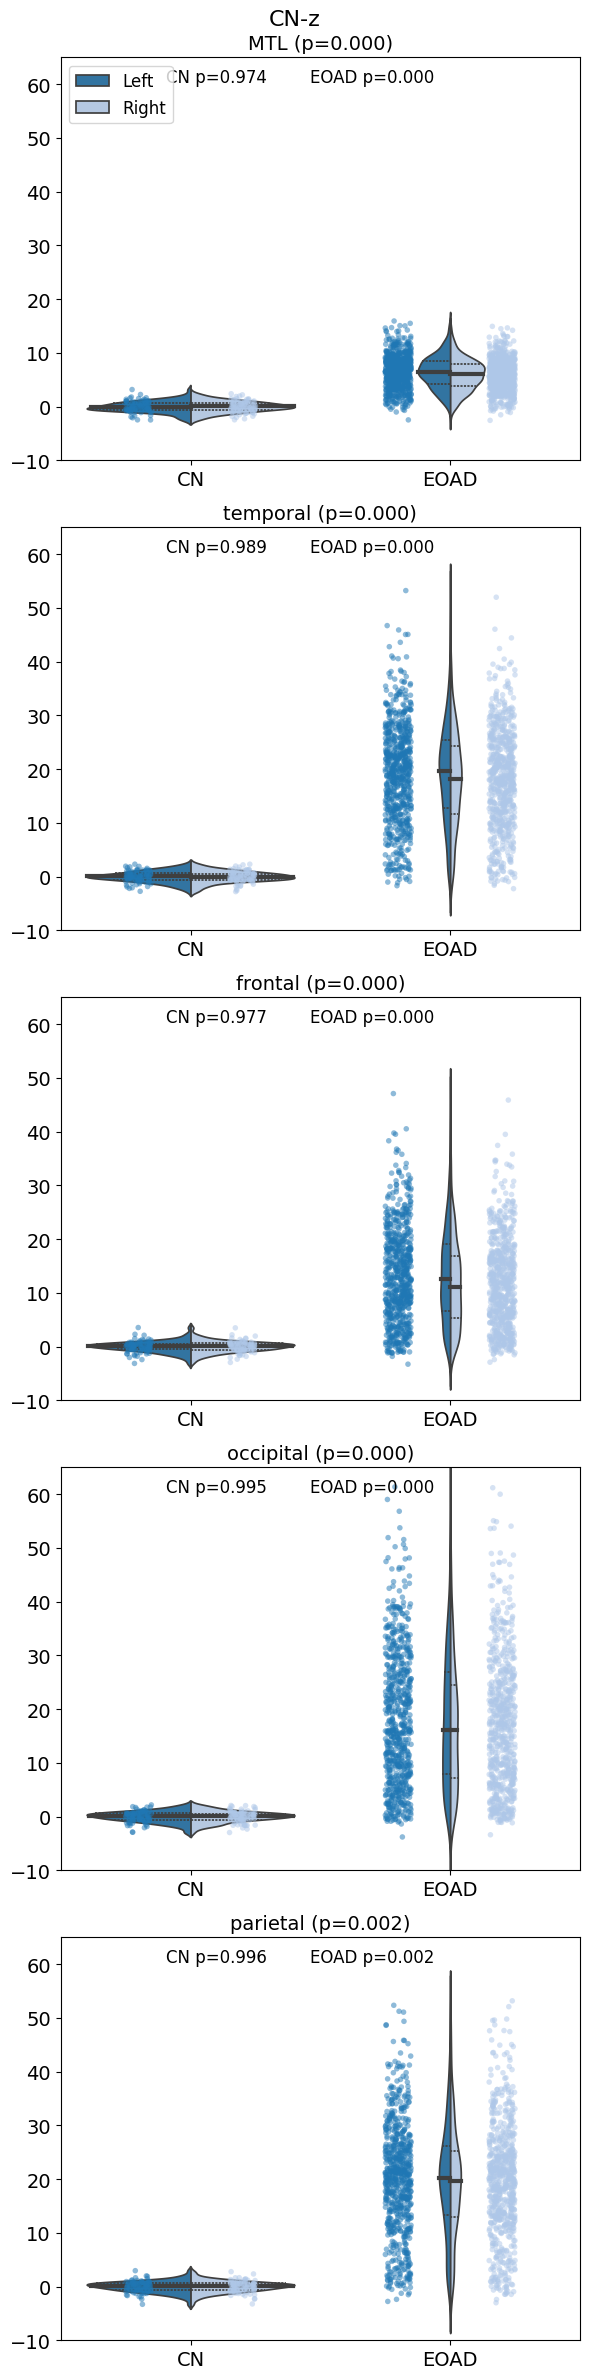

In [204]:
roi_cluster_violin(bzl,
                   title_text = 'CN-z',
                   labels = ['Left','Right'],
                   strip = True,
                   colors = sns.set_palette('tab20'),
                   range = [-10,65])

In [186]:
results.method.unique()

array(['cn', 'gmm2', 'gmm2non', 'gmm3non'], dtype=object)

In [202]:
def trans(method):
    results_mean = results[(results['stat'] == 'mean')]
    results_sd = results[(results['stat'] == 'sd')]
    
    chosen_method = method # or any other method of interest
    
    standardized_values = []

    for roi in slftp['lobe'].unique():
        mean_value = results_mean[(results_mean['roi'] == roi) & (results_mean['method'] == chosen_method)]['value'].mean()
        sd_value = results_sd[(results_sd['roi'] == roi) & (results_sd['method'] == chosen_method)]['value'].mean()
        
        fsltp_roi = slftp[slftp['lobe'] == roi].copy()
        fsltp_roi['value'] = (fsltp_roi['value'] - mean_value) / sd_value
        
        standardized_values.append(fsltp_roi)

    # Concatenate all standardized values
    fsltp = pd.concat(standardized_values)

    # Save the standardized values in the same format
    fsltp = fsltp[['subj', 'dx', 'lobe', 'value']] 
    return fsltp
    


### bgmm

In [205]:
gmm2z = trans('gmm2')
gmm2nonz = trans('gmm2non')
gmm2z.to_csv(cpath+'gmm2z_exclude.csv')
gmm2nonz.to_csv(cpath+'gmm2nonz_exclude.csv')


In [207]:
gmm2z.min()

subj     LDS0070120
dx               CN
lobe          L_MTL
value     -3.553222
dtype: object

In [208]:
gmm2z.max()

subj     LDS9410679
dx             EOAD
lobe     R_temporal
value     60.484031
dtype: object

/tmp/ipykernel_2358247/855265866.py:18: UserWarning: The palette list has more values (18) than needed (2), which may not be intended.
  sns.violinplot(data=data[data['lobe'].isin([lobe_l, lobe_r])], x='dx', y='value', hue='lobe',
/tmp/ipykernel_2358247/855265866.py:23: UserWarning: The palette list has more values (18) than needed (2), which may not be intended.
  sns.stripplot(data=data[data['lobe'].isin([lobe_l, lobe_r])], x='dx', y='value', hue='lobe',
/tmp/ipykernel_2358247/855265866.py:18: UserWarning: The palette list has more values (18) than needed (2), which may not be intended.
  sns.violinplot(data=data[data['lobe'].isin([lobe_l, lobe_r])], x='dx', y='value', hue='lobe',
/tmp/ipykernel_2358247/855265866.py:23: UserWarning: The palette list has more values (18) than needed (2), which may not be intended.
  sns.stripplot(data=data[data['lobe'].isin([lobe_l, lobe_r])], x='dx', y='value', hue='lobe',
/tmp/ipykernel_2358247/855265866.py:18: UserWarning: The palette list has more

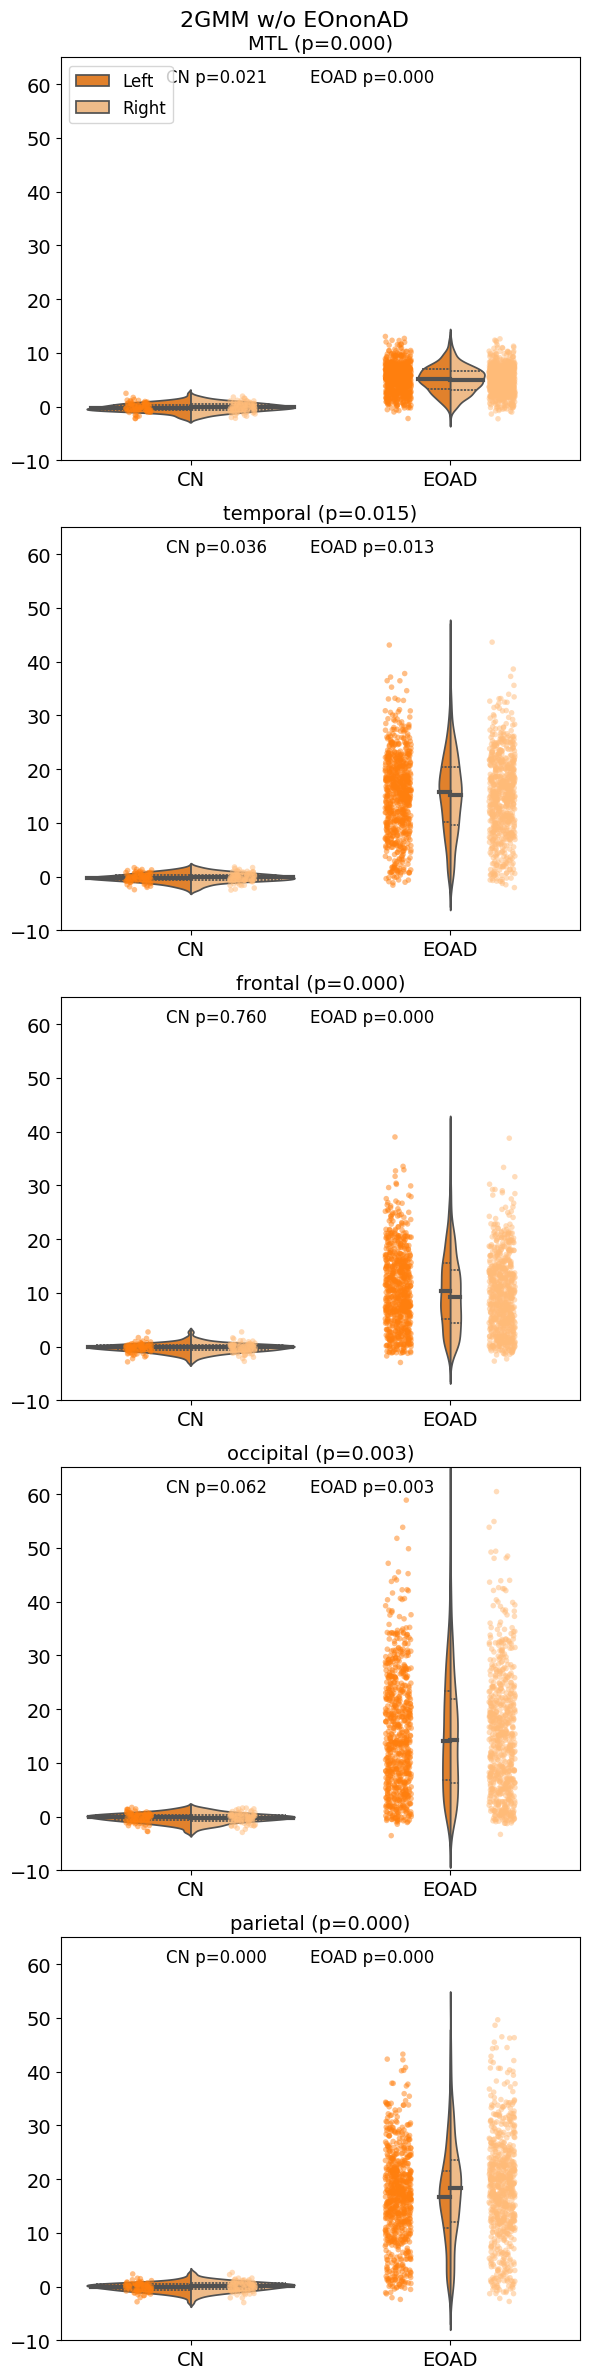

In [209]:
roi_cluster_violin(gmm2z[gmm2z.dx.isin(['EOAD','CN'])],
                   title_text = '2GMM w/o EOnonAD',
                   labels = ['Left','Right'],
                   strip = True,
                   colors = sns.color_palette('tab20')[2:],
                   range = [-10,65])

In [210]:
gmm2nonz.min()

subj     LDS0070120
dx               CN
lobe          L_MTL
value     -3.726614
dtype: object

In [211]:
gmm2nonz.max()

subj     LDS9410679
dx             EOAD
lobe     R_temporal
value     63.824922
dtype: object

/tmp/ipykernel_2358247/855265866.py:18: UserWarning: The palette list has more values (16) than needed (2), which may not be intended.
  sns.violinplot(data=data[data['lobe'].isin([lobe_l, lobe_r])], x='dx', y='value', hue='lobe',
/tmp/ipykernel_2358247/855265866.py:23: UserWarning: The palette list has more values (16) than needed (2), which may not be intended.
  sns.stripplot(data=data[data['lobe'].isin([lobe_l, lobe_r])], x='dx', y='value', hue='lobe',
/tmp/ipykernel_2358247/855265866.py:18: UserWarning: The palette list has more values (16) than needed (2), which may not be intended.
  sns.violinplot(data=data[data['lobe'].isin([lobe_l, lobe_r])], x='dx', y='value', hue='lobe',
/tmp/ipykernel_2358247/855265866.py:23: UserWarning: The palette list has more values (16) than needed (2), which may not be intended.
  sns.stripplot(data=data[data['lobe'].isin([lobe_l, lobe_r])], x='dx', y='value', hue='lobe',
/tmp/ipykernel_2358247/855265866.py:18: UserWarning: The palette list has more

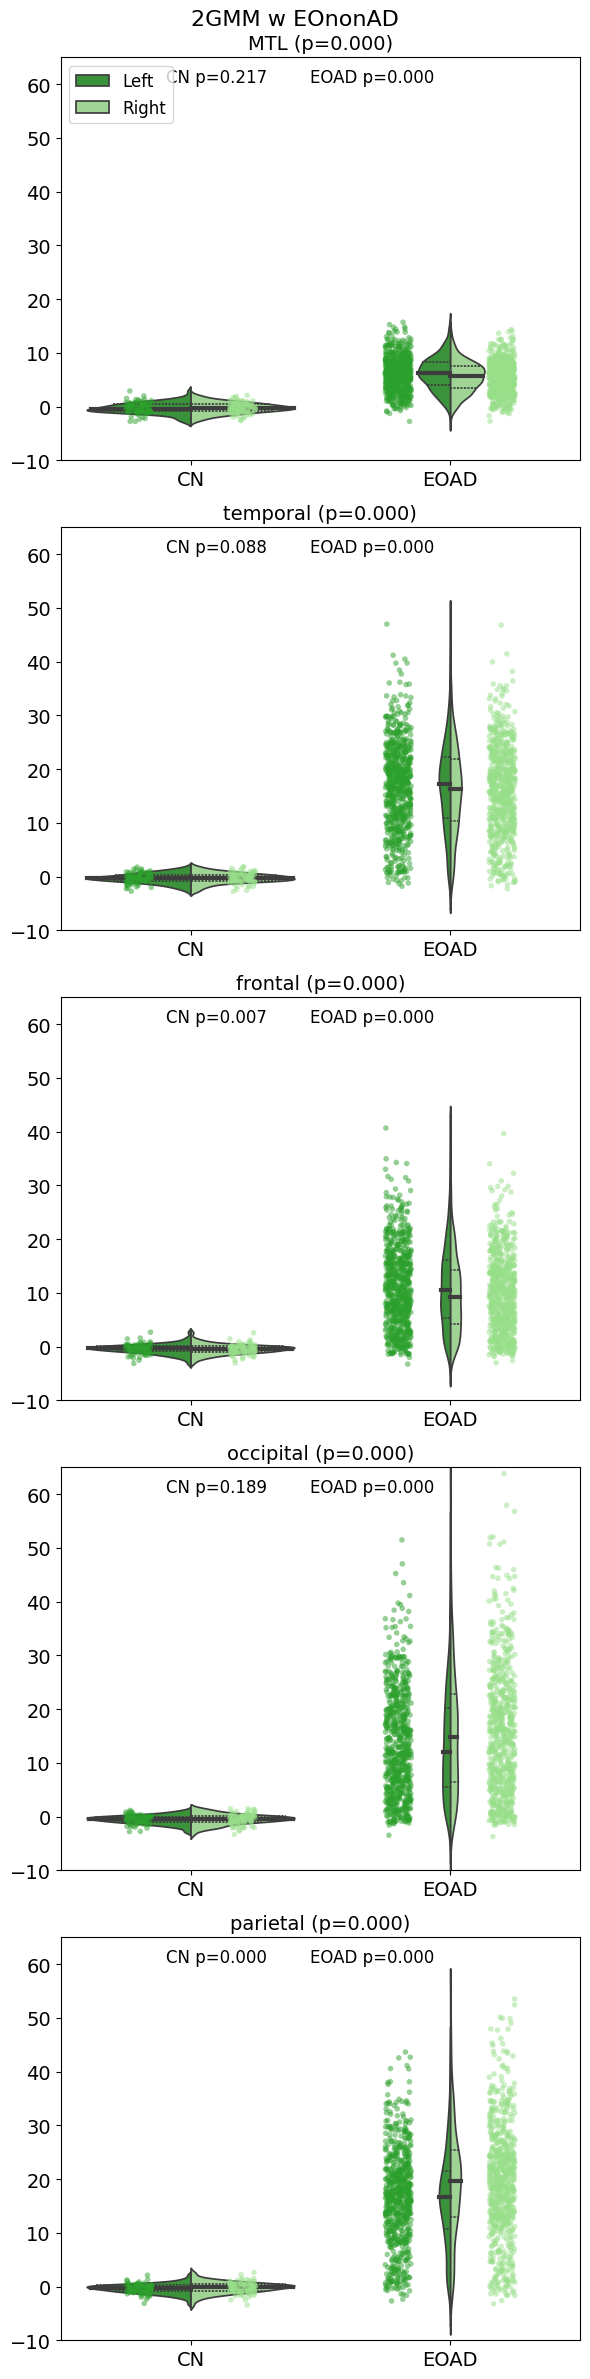

In [212]:
roi_cluster_violin(gmm2nonz[gmm2nonz.dx.isin(['EOAD','CN'])],
                   title_text = '2GMM w EOnonAD',
                   labels = ['Left','Right'],
                   strip = True,
                   colors = sns.color_palette('tab20')[4:],
                   range = [-10,65])

### 3GMM

In [213]:

gmm3nonz = trans('gmm3non')
gmm3nonz.to_csv(cpath+'gmm3nonz_exclude.csv')

In [214]:
gmm3nonz[gmm3nonz.dx.isin(['EOAD','CN'])].min()

subj     LDS0070120
dx               CN
lobe          L_MTL
value     -3.706175
dtype: object

/tmp/ipykernel_2358247/855265866.py:18: UserWarning: The palette list has more values (14) than needed (2), which may not be intended.
  sns.violinplot(data=data[data['lobe'].isin([lobe_l, lobe_r])], x='dx', y='value', hue='lobe',
/tmp/ipykernel_2358247/855265866.py:23: UserWarning: The palette list has more values (14) than needed (2), which may not be intended.
  sns.stripplot(data=data[data['lobe'].isin([lobe_l, lobe_r])], x='dx', y='value', hue='lobe',
/tmp/ipykernel_2358247/855265866.py:18: UserWarning: The palette list has more values (14) than needed (2), which may not be intended.
  sns.violinplot(data=data[data['lobe'].isin([lobe_l, lobe_r])], x='dx', y='value', hue='lobe',
/tmp/ipykernel_2358247/855265866.py:23: UserWarning: The palette list has more values (14) than needed (2), which may not be intended.
  sns.stripplot(data=data[data['lobe'].isin([lobe_l, lobe_r])], x='dx', y='value', hue='lobe',
/tmp/ipykernel_2358247/855265866.py:18: UserWarning: The palette list has more

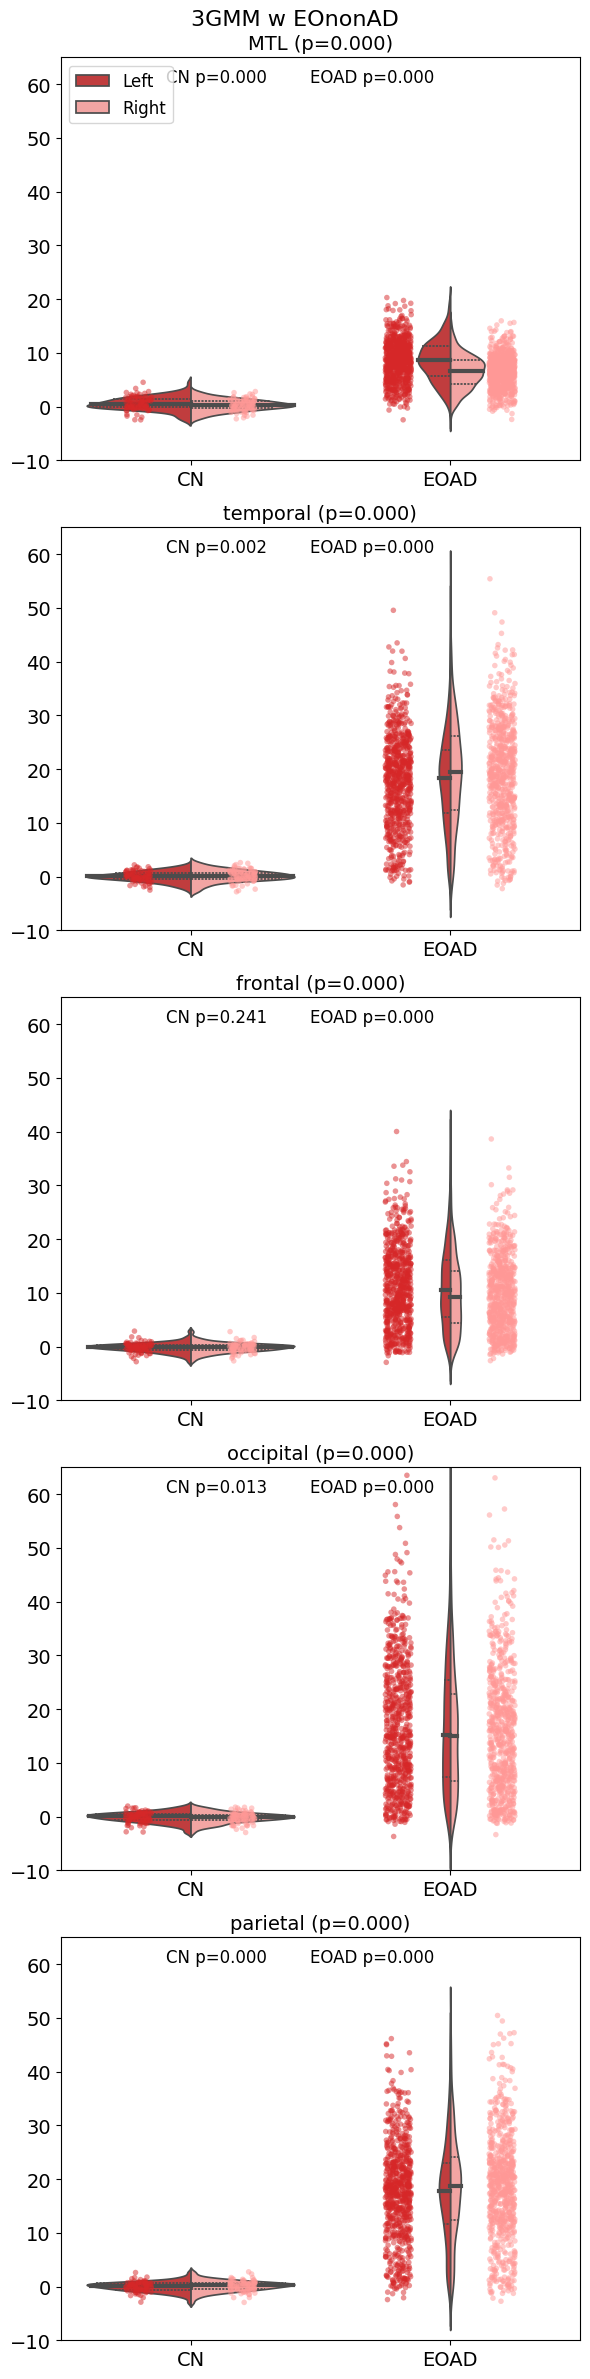

In [215]:
roi_cluster_violin(gmm3nonz[gmm3nonz.dx.isin(['EOAD','CN'])],
                   title_text = '3GMM w EOnonAD',
                   labels = ['Left','Right'],
                   strip = True,
                   colors = sns.color_palette('tab20')[6:],
                   range = [-10,65])